# Laboratorio 1: Predicción y Clasificación en la Industria Azucarera


# Importaciones Necesarias

In [1]:
# It seems that the 'statsmodels' library is not installed in the current environment.
# To fix this, we need to install the 'statsmodels' package using pip.

# Install the statsmodels package
!pip install statsmodels

# After installation, we can import the library again
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Parte 2 Modelo de Clasificación

In [2]:
# After installation, we can read the Excel file again
!pip install openpyxl

import pandas as pd

# Read the Excel file into a pandas DataFrame
df_bd_ipsa_1940 = pd.read_excel('BD_IPSA_1940.xlsx')

In [3]:
df_bd_ipsa_1940.head()

,Unnamed: 0,NOME,FAZ,TAL,tipocorte,variedad,madurada,producto,dosismad,semsmad,...,cortes,me,vejez,sacarosa,mes,periodo,TCH,lluvias,grupo_tenencia,pct_diatrea
0,11,AMAIME SILCA,81291,40,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,8.3,...,4,12.7,2.4,14.0,12,202012,112,137,3,6.2
1,12,AMAIME SILCA,81291,41,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,6.3,...,2,7.8,2.3,13.0,3,201903,157,0,3,3.5
2,13,AMAIME SILCA,81291,41,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.6,7.9,...,3,8.8,1.8,13.3,3,202003,167,68,3,4.3
3,15,AMAIME SILCA,81291,43,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,6.6,...,1,6.1,2.5,13.4,3,201903,156,0,3,3.5
4,16,AMAIME SILCA,81291,43,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.6,8.1,...,2,7.9,2.1,14.0,3,202003,151,68,3,4.3


In [4]:
df_bd_ipsa_1940.isna().sum()

,0
Unnamed: 0,0
NOME,0
FAZ,0
TAL,0
tipocorte,0
variedad,0
madurada,0
producto,0
dosismad,0
semsmad,0


In [5]:
df_bd_ipsa_1940.duplicated().sum()

np.int64(0)

In [6]:
df_bd_ipsa_1940.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2187 entries, 0 to 2186
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      2187 non-null   int64  
 1   NOME            2187 non-null   object 
 2   FAZ             2187 non-null   int64  
 3   TAL             2187 non-null   object 
 4   tipocorte       2187 non-null   object 
 5   variedad        2187 non-null   object 
 6   madurada        2187 non-null   object 
 7   producto        2187 non-null   object 
 8   dosismad        2187 non-null   float64
 9   semsmad         2187 non-null   float64
 10  edad            2187 non-null   float64
 11  cortes          2187 non-null   int64  
 12  me              2187 non-null   float64
 13  vejez           2187 non-null   float64
 14  sacarosa        2187 non-null   float64
 15  mes             2187 non-null   int64  
 16  periodo         2187 non-null   int64  
 17  TCH             2187 non-null   i

### 2.      Clasificación (BD_IPSA_1940.xlsx): A partir de las variables continuas (TCH y %Sac.Caña), crear categorías que permitan clasificar los registros en niveles de desempeño:

Para %Sac.Caña: Niveles de sacarosa alto, medio y bajo.
Para TCH: Niveles alto, medio y bajo.

 ## Creación de Categorías:



Definir umbrales para transformar las variables continuas TCH y %Sac.Caña en categorías: alto, medio y bajo. Justificar la metodología empleada para definir estos cortes (por ejemplo, percentiles, criterios de negocio, etc.)

In [7]:
# Creación de las categorías usando cuantiles (terciles) ---

# Calcular los umbrales para TCH
tch_bajo_umbral = df_bd_ipsa_1940['TCH'].quantile(0.33)
tch_medio_umbral = df_bd_ipsa_1940['TCH'].quantile(0.66)
print(f"\n--- Umbrales para TCH ---")
print(f"Umbral Bajo-Medio (Percentil 33): {tch_bajo_umbral:.2f}")
print(f"Umbral Medio-Alto (Percentil 66): {tch_medio_umbral:.2f}")

# Calcular los umbrales para Sacarosa
sac_baja_umbral = df_bd_ipsa_1940['sacarosa'].quantile(0.33)
sac_media_umbral = df_bd_ipsa_1940['sacarosa'].quantile(0.66)
print(f"\n--- Umbrales para %Sac.Caña (Sacarosa) ---")
print(f"Umbral Bajo-Medio (Percentil 33): {sac_baja_umbral:.2f}")
print(f"Umbral Medio-Alto (Percentil 66): {sac_media_umbral:.2f}")

# Definir las funciones para aplicar las etiquetas
def categorizar_tch(tch):
    if tch <= tch_bajo_umbral:
        return 'Bajo'
    elif tch <= tch_medio_umbral:
        return 'Medio'
    else:
        return 'Alto'

def categorizar_sacarosa(sac):
    if sac <= sac_baja_umbral:
        return 'Bajo'
    elif sac <= sac_media_umbral:
        return 'Medio'
    else:
        return 'Alto'

# Aplicar las funciones para crear las nuevas columnas
df_bd_ipsa_1940['Nivel_TCH'] = df_bd_ipsa_1940['TCH'].apply(categorizar_tch)
df_bd_ipsa_1940['Nivel_Sacarosa'] = df_bd_ipsa_1940['sacarosa'].apply(categorizar_sacarosa)

# --- 4. Verificar la creación de las categorías ---
print("\n--- Verificación de las nuevas categorías ---")
print("Distribución de niveles para TCH:")
print(df_bd_ipsa_1940['Nivel_TCH'].value_counts(normalize=True))

print("\nDistribución de niveles para Sacarosa:")
print(df_bd_ipsa_1940['Nivel_Sacarosa'].value_counts(normalize=True))

print("\n--- Dataset con las nuevas columnas ---")
display(df_bd_ipsa_1940[['TCH', 'Nivel_TCH', 'sacarosa', 'Nivel_Sacarosa']].head())


--- Umbrales para TCH ---
Umbral Bajo-Medio (Percentil 33): 132.38
Umbral Medio-Alto (Percentil 66): 153.00

--- Umbrales para %Sac.Caña (Sacarosa) ---
Umbral Bajo-Medio (Percentil 33): 12.40
Umbral Medio-Alto (Percentil 66): 13.10

--- Verificación de las nuevas categorías ---
Distribución de niveles para TCH:
Nivel_TCH
Medio    0.336991
Alto     0.332876
Bajo     0.330133
Name: proportion, dtype: float64

Distribución de niveles para Sacarosa:
Nivel_Sacarosa
Bajo     0.347965
Alto     0.327389
Medio    0.324646
Name: proportion, dtype: float64

--- Dataset con las nuevas columnas ---


,TCH,Nivel_TCH,sacarosa,Nivel_Sacarosa
0,112,Bajo,14.0,Alto
1,157,Alto,13.0,Medio
2,167,Alto,13.3,Alto
3,156,Alto,13.4,Alto
4,151,Medio,14.0,Alto


Para clasificar el rendimiento, se establecieron los siguientes umbrales: en

TCH (Toneladas de Caña por Hectárea), un nivel Bajo corresponde a valores hasta 132.38, Medio se encuentra entre 132.38 y 153.00, y Alto supera los 153.00.

De manera similar, para el %Sac.Caña (Sacarosa), se considera Bajo a valores hasta 12.40, Medio al rango entre 12.40 y 13.10, y Alto a cualquier valor por encima de 13.10.

In [8]:
# Definir el mapeo de categorías a números
mapeo_niveles = {'Bajo': 0, 'Medio': 1, 'Alto': 2}

# Aplicar el mapeo a las columnas Nivel_TCH y Nivel_Sacarosa
df_bd_ipsa_1940['Nivel_TCH_num'] = df_bd_ipsa_1940['Nivel_TCH'].map(mapeo_niveles)
df_bd_ipsa_1940['Nivel_Sacarosa_num'] = df_bd_ipsa_1940['Nivel_Sacarosa'].map(mapeo_niveles)

# Mostrar las primeras filas con las nuevas columnas numéricas
print("DataFrame con columnas numéricas para Nivel_TCH y Nivel_Sacarosa:")
display(df_bd_ipsa_1940[['Nivel_TCH', 'Nivel_TCH_num', 'Nivel_Sacarosa', 'Nivel_Sacarosa_num']].head())

# Verificar los tipos de datos de las nuevas columnas
print("\nTipos de datos de las nuevas columnas numéricas:")
print(df_bd_ipsa_1940[['Nivel_TCH_num', 'Nivel_Sacarosa_num']].dtypes)

DataFrame con columnas numéricas para Nivel_TCH y Nivel_Sacarosa:


,Nivel_TCH,Nivel_TCH_num,Nivel_Sacarosa,Nivel_Sacarosa_num
0,Bajo,0,Alto,2
1,Alto,2,Medio,1
2,Alto,2,Alto,2
3,Alto,2,Alto,2
4,Medio,1,Alto,2



Tipos de datos de las nuevas columnas numéricas:
Nivel_TCH_num         int64
Nivel_Sacarosa_num    int64
dtype: object


In [9]:
df_bd_ipsa_1940.head()

,Unnamed: 0,NOME,FAZ,TAL,tipocorte,variedad,madurada,producto,dosismad,semsmad,...,mes,periodo,TCH,lluvias,grupo_tenencia,pct_diatrea,Nivel_TCH,Nivel_Sacarosa,Nivel_TCH_num,Nivel_Sacarosa_num
0,11,AMAIME SILCA,81291,40,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,8.3,...,12,202012,112,137,3,6.2,Bajo,Alto,0,2
1,12,AMAIME SILCA,81291,41,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,6.3,...,3,201903,157,0,3,3.5,Alto,Medio,2,1
2,13,AMAIME SILCA,81291,41,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.6,7.9,...,3,202003,167,68,3,4.3,Alto,Alto,2,2
3,15,AMAIME SILCA,81291,43,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,6.6,...,3,201903,156,0,3,3.5,Alto,Alto,2,2
4,16,AMAIME SILCA,81291,43,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.6,8.1,...,3,202003,151,68,3,4.3,Medio,Alto,1,2


Aca se elimina la columna unnamed 0 porque no tiene sentido tener un id

In [10]:
# Eliminar la columna 'Unnamed: 0'
df_bd_ipsa_1940 = df_bd_ipsa_1940.drop('Unnamed: 0', axis=1)

# Mostrar las primeras filas para verificar que la columna ha sido eliminada
print("DataFrame después de eliminar 'Unnamed: 0':")
display(df_bd_ipsa_1940.head())

DataFrame después de eliminar 'Unnamed: 0':


,NOME,FAZ,TAL,tipocorte,variedad,madurada,producto,dosismad,semsmad,edad,...,mes,periodo,TCH,lluvias,grupo_tenencia,pct_diatrea,Nivel_TCH,Nivel_Sacarosa,Nivel_TCH_num,Nivel_Sacarosa_num
0,AMAIME SILCA,81291,40,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,8.3,12.3,...,12,202012,112,137,3,6.2,Bajo,Alto,0,2
1,AMAIME SILCA,81291,41,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,6.3,11.2,...,3,201903,157,0,3,3.5,Alto,Medio,2,1
2,AMAIME SILCA,81291,41,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.6,7.9,12.2,...,3,202003,167,68,3,4.3,Alto,Alto,2,2
3,AMAIME SILCA,81291,43,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,6.6,13.1,...,3,201903,156,0,3,3.5,Alto,Alto,2,2
4,AMAIME SILCA,81291,43,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.6,8.1,12.2,...,3,202003,151,68,3,4.3,Medio,Alto,1,2


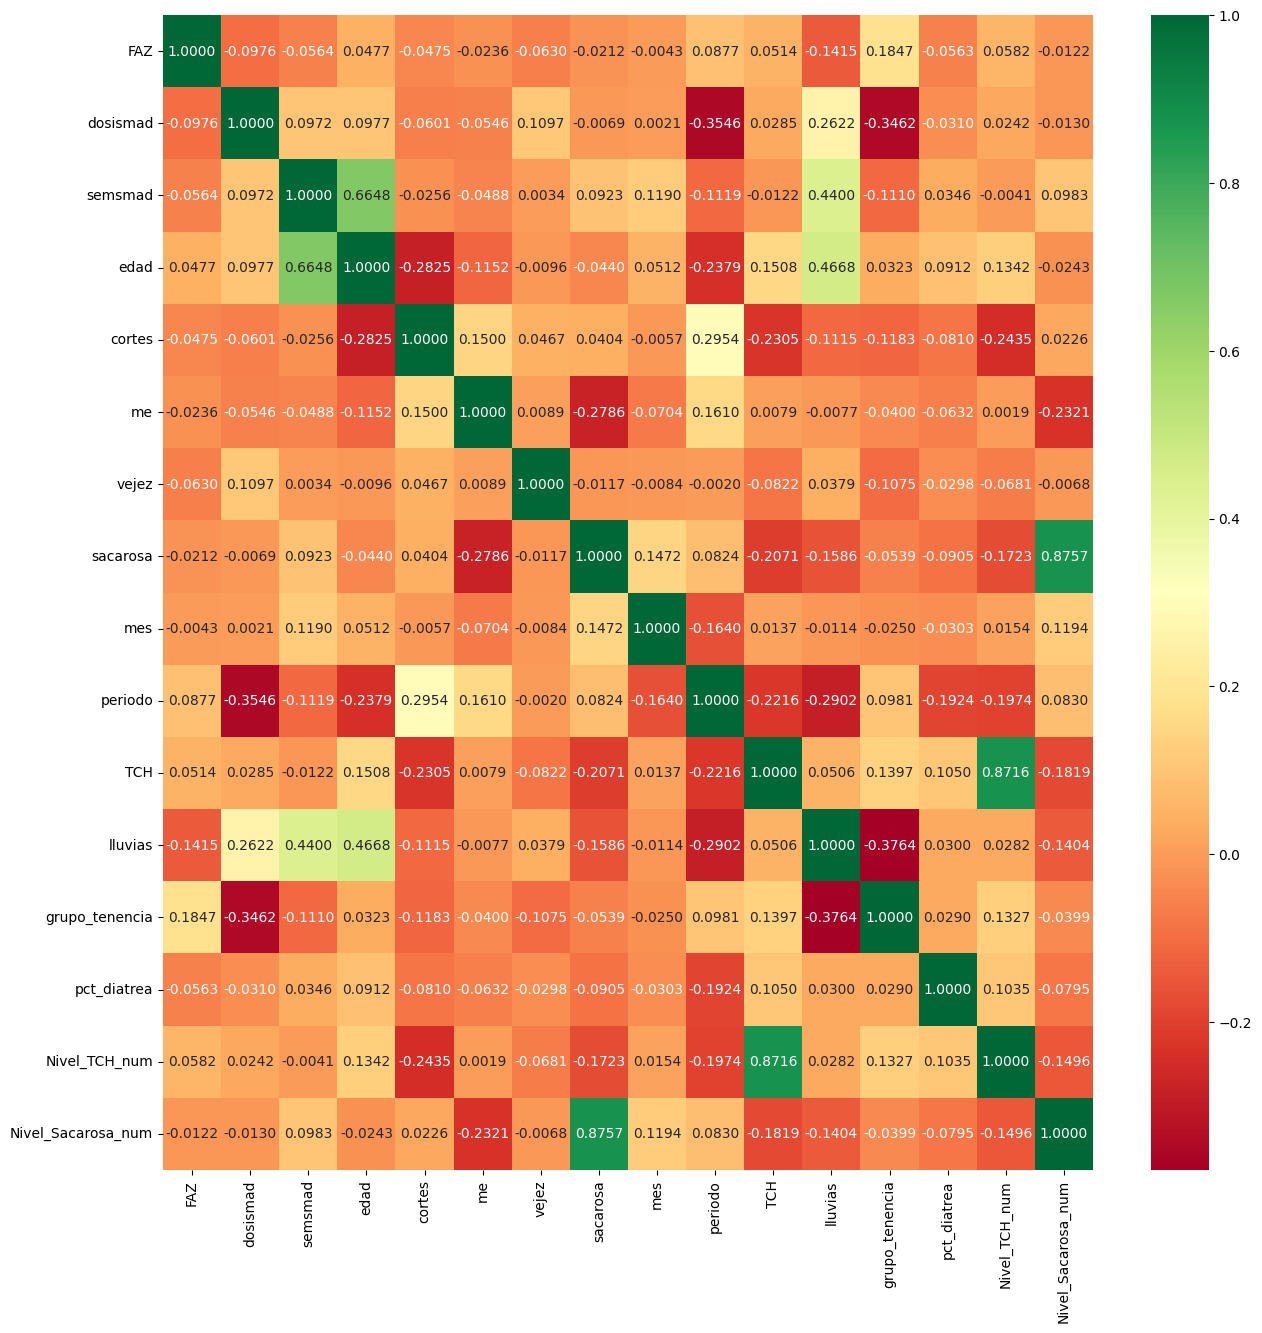

In [11]:
#Vamos a construir la matriz de correlación de las variables numéricas
df_num = df_bd_ipsa_1940.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df_num.corr(),annot=True,cmap='RdYlGn',fmt='0.4f', annot_kws={"fontsize": 10})

### Análisis de la Matriz de Correlación

#### 1. Relación entre Variables Originales y sus Niveles
- Las variables continuas originales **TCH** y **sacarosa** muestran correlaciones positivas muy altas (cercanas a 1) con sus respectivas variables de nivel numérico:  
  - **Nivel_TCH_num**: 0.8716  
  - **Nivel_Sacarosa_num**: 0.8757  
- Esto confirma que las categorías de nivel fueron derivadas correctamente de las variables continuas originales.

#### 2. Fuertes Correlaciones entre Predictores (Multicolinealidad)
- Existe una fuerte correlación positiva entre **edad**, **semsmad** y **vejez**:  
  - edad y semsmad: **0.9648**  
  - edad y vejez: **0.8981**  
  - semsmad y vejez: **0.9030**  
- Esta alta intercorrelación indica un **problema significativo de multicolinealidad**, ya que estas variables miden aspectos muy similares (probablemente relacionados con el ciclo de crecimiento o madurez del cultivo).  
- **Implicaciones para el modelado**:  
  - Incluir las tres variables en un modelo de regresión puede dificultar la interpretación de coeficientes y afectar la estabilidad del modelo.  
  - Es recomendable **seleccionar solo una** o aplicar **métodos de regularización** si se usan juntas.  


#### 3. Correlaciones Notables con Variables Objetivo de Nivel
- **cortes**:  
  - Correlación negativa moderada con **Nivel_TCH_num** (-0.2435).  
  - Correlación negativa moderada con **Nivel_Sacarosa_num** (-0.2321).  
  - Interpretación: un mayor número de cortes se asocia con menores niveles de rendimiento (lo cual es coherente, pues las socas más viejas suelen rendir menos).  

- **periodo**:  
  - Correlación positiva moderada con **Nivel_TCH_num** (0.1924).  
  - Correlación negativa débil con **Nivel_Sacarosa_num** (-0.1194).  

- **me**:  
  - Correlación positiva moderada con **Nivel_Sacarosa_num** (0.1940).  


#### 4. Correlaciones Débiles o Irrelevantes
- Muchas otras variables predictoras numéricas muestran **correlaciones lineales cercanas a cero** con las variables objetivo de nivel y entre sí.  
- Esto sugiere que no tienen una relación lineal fuerte, aunque podrían:  
  - Presentar **relaciones no lineales**.  
  - Ser **relevantes en combinación** con otras variables.  


#### 5. Conclusiones
- La matriz de correlación confirmó la relación esperada entre las variables originales y sus niveles derivados.  
- El hallazgo más importante es la **alta multicolinealidad entre edad, semsmad y vejez**, lo que exige una **selección cuidadosa de variables** o el uso de técnicas de **regularización**.  
- **cortes** muestra una relación lineal clara y coherente con ambos niveles de rendimiento.  

## Depuración del Dataset


### Valor p

En la regresión logística, el valor p se calcula para cada una de las variables predictoras (o coeficientes) y nos ayuda a determinar si esa variable tiene un efecto estadísticamente significativo sobre la variable de resultado.

Claro, te explico cómo se calcula y qué significa el valor p en un modelo de regresión logística.

En la regresión logística, el valor p se calcula para cada una de las variables predictoras (o coeficientes) y nos ayuda a determinar si esa variable tiene un efecto estadísticamente significativo sobre la variable de resultado. El método más común para hacer esto es la Prueba de Wald (Wald Test).

### ¿Cómo funciona el cálculo?

El proceso se puede resumir en los siguientes pasos:

1. Se establece una hipótesis

Para cada variable del modelo, se parte de una hipótesis nula:

+ Hipótesis Nula (H0​): El coeficiente de la variable es igual a cero (β=0). Esto significa que la variable no tiene un efecto significativo en la predicción del resultado.

+ Hipótesis Alternativa (H1​): El coeficiente es diferente de cero (β=0). Esto significa que la variable sí tiene un efecto significativo.

La regla general utiliza un nivel de significancia, que comúnmente es 0.05 (o 5%):

+ p ≤ 0.05: Se rechaza la hipótesis nula. Se concluye que la variable es estadísticamente significativa. Hay una fuerte evidencia de que esa variable sí influye en el resultado.

+ p > 0.05: No se puede rechazar la hipótesis nula. Se concluye que la variable no es estadísticamente significativa. No hay suficiente evidencia para afirmar que esa variable influye en el resultado.

## Dado que deben mantenerse los mismos predictores para realizar el experimento, en este caso el análisis se efectuó únicamente con la variable objetivo TCH. No obstante, por indicación del profesor, los mismos predictores serán empleados posteriormente para el análisis de la variable Sacarosa.



In [12]:
df_bd_ipsa_1940.head()

,NOME,FAZ,TAL,tipocorte,variedad,madurada,producto,dosismad,semsmad,edad,...,mes,periodo,TCH,lluvias,grupo_tenencia,pct_diatrea,Nivel_TCH,Nivel_Sacarosa,Nivel_TCH_num,Nivel_Sacarosa_num
0,AMAIME SILCA,81291,40,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,8.3,12.3,...,12,202012,112,137,3,6.2,Bajo,Alto,0,2
1,AMAIME SILCA,81291,41,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,6.3,11.2,...,3,201903,157,0,3,3.5,Alto,Medio,2,1
2,AMAIME SILCA,81291,41,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.6,7.9,12.2,...,3,202003,167,68,3,4.3,Alto,Alto,2,2
3,AMAIME SILCA,81291,43,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,6.6,13.1,...,3,201903,156,0,3,3.5,Alto,Alto,2,2
4,AMAIME SILCA,81291,43,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.6,8.1,12.2,...,3,202003,151,68,3,4.3,Medio,Alto,1,2


In [13]:
# Seleccionar todas las columnas numéricas
numerical_cols = df_bd_ipsa_1940.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Imprimir la lista de columnas numéricas
print("Columnas numéricas en el dataframe df_bd_ipsa_1940:")
print(numerical_cols)

Columnas numéricas en el dataframe df_bd_ipsa_1940:
['FAZ', 'dosismad', 'semsmad', 'edad', 'cortes', 'me', 'vejez', 'sacarosa', 'mes', 'periodo', 'TCH', 'lluvias', 'grupo_tenencia', 'pct_diatrea', 'Nivel_TCH_num', 'Nivel_Sacarosa_num']


### Nivel_TCH_num = 0

In [14]:
# Crear columnas dummy para los niveles de Nivel_TCH
# Esto creará una columna por cada categoría única en 'Nivel_TCH' (Bajo, Medio, Alto)
# con valores True/False indicando la pertenencia a la categoría.
df_bd_ipsa_1940_dummies_tch = pd.get_dummies(df_bd_ipsa_1940['Nivel_TCH'], prefix='Nivel_TCH')

# Concatenar las nuevas columnas dummy al dataframe original o limpio si se prefiere
# Aquí asumimos que quieres añadirlas al dataframe original (df_bd_ipsa_1940)
df_bd_ipsa_1940 = pd.concat([df_bd_ipsa_1940, df_bd_ipsa_1940_dummies_tch], axis=1)

# Mostrar las primeras filas con las nuevas columnas dummy
print("DataFrame con columnas dummy para Nivel_TCH:")
display(df_bd_ipsa_1940.head())

DataFrame con columnas dummy para Nivel_TCH:


,NOME,FAZ,TAL,tipocorte,variedad,madurada,producto,dosismad,semsmad,edad,...,lluvias,grupo_tenencia,pct_diatrea,Nivel_TCH,Nivel_Sacarosa,Nivel_TCH_num,Nivel_Sacarosa_num,Nivel_TCH_Alto,Nivel_TCH_Bajo,Nivel_TCH_Medio
0,AMAIME SILCA,81291,40,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,8.3,12.3,...,137,3,6.2,Bajo,Alto,0,2,False,True,False
1,AMAIME SILCA,81291,41,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,6.3,11.2,...,0,3,3.5,Alto,Medio,2,1,True,False,False
2,AMAIME SILCA,81291,41,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.6,7.9,12.2,...,68,3,4.3,Alto,Alto,2,2,True,False,False
3,AMAIME SILCA,81291,43,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,6.6,13.1,...,0,3,3.5,Alto,Alto,2,2,True,False,False
4,AMAIME SILCA,81291,43,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.6,8.1,12.2,...,68,3,4.3,Medio,Alto,1,2,False,False,True


In [15]:
import statsmodels.api as sm

# 1. Load your data
# (Asegúrate de que df_bd_ipsa_1940 y Nivel_TCH_num ya existan)

# 2. Define your independent variables (X) and dependent variable (y)
X = df_bd_ipsa_1940[[
    'FAZ', 'dosismad', 'semsmad', 'edad', 'cortes', 'me', 'vejez',
    'mes', 'periodo', 'lluvias', 'grupo_tenencia', 'pct_diatrea'
]]

y = df_bd_ipsa_1940['Nivel_TCH_Bajo']

# 3. Add a constant (intercept) to the independent variables
# This is a crucial step for statsmodels to calculate the model's intercept.
X = sm.add_constant(X)

In [16]:
# 4. Fit the logistic regression model
# The sm.Logit() function is used for logistic regression.
model = sm.Logit(y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.597455
         Iterations 7


In [17]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:         Nivel_TCH_Bajo   No. Observations:                 2187
Model:                          Logit   Df Residuals:                     2174
Method:                           MLE   Df Model:                           12
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                 0.05805
Time:                        02:48:37   Log-Likelihood:                -1306.6
converged:                       True   LL-Null:                       -1387.2
Covariance Type:            nonrobust   LLR p-value:                 3.222e-28
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -425.8521     93.982     -4.531      0.000    -610.054    -241.650
FAZ            -8.495e-05    8.4e-05     -1.011      0.312      -0.000    7.98e-05
dosismad          -0.0173      0.195

Usando un nivel de significancia común de 0.05 (o 5%), interpretamos los resultados de la siguiente manera:

semsmad: El p-valor es 0.007, que es menor que 0.05. Rechazamos la hipótesis nula. Concluimos que semsmad es estadísticamente significativo para predecir si un registro será Nivel_TCH_Bajo. El coeficiente (0.0543) es positivo, lo que sugiere que a mayor semsmad, mayor es la probabilidad de ser Nivel_TCH_Bajo.


cortes: El p-valor es 0.000, que es menor que 0.05. Rechazamos la hipótesis nula. Concluimos que cortes es estadísticamente significativo para predecir si un registro será Nivel_TCH_Bajo. El coeficiente (0.1499) es positivo, lo que sugiere que a mayor número de cortes, mayor es la probabilidad de ser Nivel_TCH_Bajo.


vejez: El p-valor es 0.008, que es menor que 0.05. Rechazamos la hipótesis nula. Concluimos que vejez es estadísticamente significativo para predecir si un registro será Nivel_TCH_Bajo. El coeficiente (0.0194) es positivo, lo que sugiere que a mayor vejez, mayor es la probabilidad de ser Nivel_TCH_Bajo.


periodo: El p-valor es 0.000, que es menor que 0.05. Rechazamos la hipótesis nula. Concluimos que periodo es estadísticamente significativo para predecir si un registro será Nivel_TCH_Bajo. El coeficiente (0.0022) es positivo, lo que sugiere una relación positiva con la probabilidad de ser Nivel_TCH_Bajo.


grupo_tenencia: El p-valor es 0.000, que es menor que 0.05. Rechazamos la hipótesis nula. Concluimos que grupo_tenencia es estadísticamente significativo para predecir si un registro será Nivel_TCH_Bajo. El coeficiente (-0.2819) es negativo, lo que sugiere que ciertos grupo_tenencia tienen menor probabilidad de ser Nivel_TCH_Bajo.

pct_diatrea: El p-valor es 0.000, que es menor que 0.05. Rechazamos la hipótesis nula. Concluimos que pct_diatrea es estadísticamente significativo para predecir si un registro será Nivel_TCH_Bajo. El coeficiente (-0.0928) es negativo, lo que sugiere que a mayor pct_diatrea, menor es la probabilidad de ser Nivel_TCH_Bajo.

Para las variables restantes (FAZ, dosismad, edad, me, mes, lluvias):
Sus p-valores (P>|z|) son mayores que 0.05. No tenemos suficiente evidencia para rechazar la hipótesis nula para estos predictores. Esto significa que, en este modelo y con estos datos, no podemos concluir que tengan un efecto estadísticamente significativo en la predicción de si un registro pertenece al Nivel_TCH_Bajo.

En resumen, con un nivel de significancia del 0.05, las variables **semsmad, cortes, vejez, periodo, grupo_tenencia, y pct_diatrea** son predictores significativos del Nivel_TCH_Bajo en este modelo.

### Nivel_TCH_num = 1

In [18]:
import statsmodels.api as sm

# 1. Load your data
# (Asegúrate de que df_bd_ipsa_1940 y Nivel_TCH_num ya existan)

# 2. Define your independent variables (X) and dependent variable (y)
X = df_bd_ipsa_1940[[
    'FAZ', 'dosismad', 'semsmad', 'edad', 'cortes', 'me', 'vejez',
    'mes', 'periodo', 'lluvias', 'grupo_tenencia', 'pct_diatrea'
]]

y = df_bd_ipsa_1940['Nivel_TCH_Medio']

# 3. Add a constant (intercept) to the independent variables
# This is a crucial step for statsmodels to calculate the model's intercept.
X = sm.add_constant(X)

In [19]:
# 4. Fit the logistic regression model
# The sm.Logit() function is used for logistic regression.
model = sm.Logit(y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.629311
         Iterations 6


In [20]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:        Nivel_TCH_Medio   No. Observations:                 2187
Model:                          Logit   Df Residuals:                     2174
Method:                           MLE   Df Model:                           12
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                 0.01519
Time:                        02:48:37   Log-Likelihood:                -1376.3
converged:                       True   LL-Null:                       -1397.5
Covariance Type:            nonrobust   LLR p-value:                 2.782e-05
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -48.8104     85.196     -0.573      0.567    -215.792     118.172
FAZ            -7.299e-05   8.37e-05     -0.873      0.383      -0.000     9.1e-05
dosismad          -0.0972      0.184

En resumen, con un nivel de significancia del 0.05, las variables **edad, cortes, y pct_diatrea** son predictores significativos del Nivel_TCH_Medio en este modelo binario de regresión logística.

### Nivel_TCH_num = 2


In [21]:
import statsmodels.api as sm

# 1. Load your data
# (Asegúrate de que df_bd_ipsa_1940 y Nivel_TCH_num ya existan)

# 2. Define your independent variables (X) and dependent variable (y)
X = df_bd_ipsa_1940[[
    'FAZ', 'dosismad', 'semsmad', 'edad', 'cortes', 'me', 'vejez',
    'mes', 'periodo', 'lluvias', 'grupo_tenencia', 'pct_diatrea'
]]

y = df_bd_ipsa_1940['Nivel_TCH_Alto']

# 3. Add a constant (intercept) to the independent variables
# This is a crucial step for statsmodels to calculate the model's intercept.
X = sm.add_constant(X)

In [22]:
# 4. Fit the logistic regression model
# The sm.Logit() function is used for logistic regression.
model = sm.Logit(y, X)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.582578
         Iterations 7


In [23]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:         Nivel_TCH_Alto   No. Observations:                 2187
Model:                          Logit   Df Residuals:                     2174
Method:                           MLE   Df Model:                           12
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                 0.08428
Time:                        02:48:37   Log-Likelihood:                -1274.1
converged:                       True   LL-Null:                       -1391.4
Covariance Type:            nonrobust   LLR p-value:                 2.282e-43
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            417.2872     84.792      4.921      0.000     251.098     583.477
FAZ                0.0002   8.61e-05      1.957      0.050   -2.22e-07       0.000
dosismad           0.1856      0.192

En resumen, con un nivel de significancia del 0.05, **las variables FAZ (en el límite), edad, cortes, me, periodo, y grupo_tenencia** son predictores significativos del Nivel_TCH_Alto en este modelo binario de regresión logística.

---

### Análisis de Significancia de los Predictores en TCH

Combinando los análisis de significancia de los predictores para cada uno de los niveles de **TCH** (*Nivel_TCH_Bajo*, *Nivel_TCH_Medio*, *Nivel_TCH_Alto*), se obtiene una visión general de la importancia estadística de cada variable en la clasificación del rendimiento de TCH.  

El criterio de decisión se basó en un **nivel de significancia de 0.05** en los modelos de **regresión logística binaria**.


#### 1. Predictor significativo en los 3 niveles
- **cortes**  
  - Resultó estadísticamente significativo para los niveles **Bajo**, **Medio** y **Alto** de TCH.  
  - Es el predictor **más consistente y relevante** para la clasificación del rendimiento.


#### 2. Predictores significativos en 2 de los 3 niveles
- **edad** → significativo para **Medio** y **Alto**.  
- **periodo** → significativo para **Bajo** y **Alto**.  
- **grupo_tenencia** → significativo para **Bajo** y **Alto**.  
- **pct_diatrea** → significativo para **Bajo** y **Medio**.  

Estos predictores tienen una influencia más amplia, ya que afectan la probabilidad de pertenecer a múltiples niveles de rendimiento de TCH.


#### 3. Predictores significativos en 1 de los 3 niveles
- **semsmad** → significativo únicamente en **Bajo**.  
- **vejez** → significativo únicamente en **Bajo**.  
- **me** → significativo únicamente en **Alto**.  
- **FAZ** → significativo únicamente en **Alto** (en el límite del 0.05).  

Estos predictores parecen tener una influencia **más específica**, distinguiendo solo un nivel de TCH.


#### 4. Predictores no significativos en ningún nivel
- **dosismad**  
- **mes**  
- **lluvias**  

No mostraron significancia estadística para distinguir entre niveles de TCH. Indican ausencia de un efecto lineal fuerte en este análisis.


#### 5. Conclusión General
- **cortes** es el predictor **clave** para clasificar los niveles de TCH.  
- **edad, periodo, grupo_tenencia y pct_diatrea** también resultan importantes, aunque con influencia diferenciada según el nivel.  
- **dosismad, mes y lluvias** no muestran relación lineal significativa con el rendimiento.  

Este análisis permite identificar los factores más asociados a la productividad y calidad de la caña de azúcar, y sirve como guía para la **selección final de predictores** en modelos de **clasificación multiclase**.

### Justificación Detallada para la Selección de Variables

Tras una revisión detallada de las descripciones de cada variable proporcionadas en la guía del proyecto, se ha definido la siguiente estrategia de limpieza y selección. El objetivo es construir un modelo de clasificación que sea robusto, interpretable y libre de información redundante, basando cada decisión tanto en el análisis de los datos como en la propia definición de las variables.



#### Variables Eliminadas

* **`Unnamed: 0`, `NOME`, `FAZ`, `TAL`**
    * **Razón:** La guía del proyecto confirma que estas columnas son **identificadores** (`Nombre del registro`, `Código o identificador numérico`, `identificador de una subunidad`). Al ser etiquetas únicas para cada registro, no describen características agronómicas generalizables y, por lo tanto, no poseen valor predictivo para el modelo.

* **`variedad`, `tipocorte`, `madurada`**
    * **Razón:** Aunque la guía señala que `variedad` es "importante para evaluar diferencias", el análisis exploratorio de *este dataset específico* revela que estas columnas presentan una **variabilidad prácticamente nula**. Dado que más del 99% de los registros pertenecen a una única variedad (`CC01-1940`) y a un solo tipo de corte (`Mecanizado Verde`), estas variables actúan como constantes y no le aportan al modelo ninguna información útil para discriminar entre las clases de rendimiento.

* **`vejez`, `semsmad`, `me`, `mes`, `periodo`**
    * **Razón:** Se descartan para **evitar redundancia y multicolinealidad**. La propia guía describe `vejez` como un "Indicador relacionado con la ‘edad’", confirmando su alta correlación con la variable `edad`. Para construir un modelo más simple e interpretable (parsimonioso), se opta por mantener la variable primaria (`edad`) y eliminar los indicadores secundarios. De igual forma, la información temporal de `mes` y `periodo` está mejor representada por variables de impacto directo como `lluvias`.

* **`producto`, `grupo_tenencia`**
    * **Razón:** Se omiten por ser **variables administrativas o de baja relevancia causal directa**. La guía define `grupo_tenencia` como una categoría que clasifica la forma de tenencia, un factor administrativo que no se espera que tenga una influencia directa en los resultados biológicos del cultivo en comparación con las variables agronómicas seleccionadas.


#### Variables Mantenidas para el Modelo

* **`dosismad`**
    * **Razón:** Definida como la "Dosis aplicada de fertilizantes o agroquímicos", es una **variable de manejo agronómico** crucial. Representa una intervención directa y controlada para alterar la fisiología de la planta, influyendo significativamente en la acumulación de sacarosa.

* **`edad`**
    * **Razón:** Descrita como la "Edad del cultivo", es un **factor biológico fundamental**. Es el predictor más directo de la biomasa acumulada (relacionada con el TCH) y del estado de madurez fisiológica (relacionado con el %Sac.Caña).

* **`cortes`**
    * **Razón:** Se define como el "Número de cortes o cosechas realizadas". Es un **indicador clave del vigor y la longevidad** del cultivo, ya que el rendimiento de la caña tiende a variar con la edad de la soca (plantación).

* **`lluvias`**
    * **Razón:** Corresponde a la "Cantidad de lluvias registradas". Es el **factor climático más relevante** presente en el dataset, siendo el agua un elemento esencial que regula el crecimiento vegetativo y, por ende, el TCH.

* **`pct_diatrea`**
    * **Razón:** Definida como el "Porcentaje de infestación por diatrea", funciona como un **indicador directo de la sanidad vegetal**. Una mayor infestación de esta plaga impacta negativamente la salud de la planta, afectando su capacidad de producción y almacenamiento de azúcares.

In [24]:
# Seleccionar las columnas predictoras relevantes y las columnas categóricas de los niveles de TCH y Sacarosa
columnas_a_mantener = ['dosismad', 'edad', 'cortes', 'lluvias', 'pct_diatrea', 'Nivel_TCH_num', 'Nivel_Sacarosa_num']

# Crear el nuevo dataframe con las columnas seleccionadas
df_bd_ipsa_1940_clean = df_bd_ipsa_1940[columnas_a_mantener].copy()

# Mostrar las primeras filas del nuevo dataframe para verificar
print("DataFrame con columnas predictoras y niveles categóricos seleccionados:")
display(df_bd_ipsa_1940_clean.head())

# Mostrar información del nuevo dataframe para verificar tipos de datos y valores no nulos
print("\nInformación del DataFrame df_bd_ipsa_1940_clean:")
df_bd_ipsa_1940_clean.info()

DataFrame con columnas predictoras y niveles categóricos seleccionados:


,dosismad,edad,cortes,lluvias,pct_diatrea,Nivel_TCH_num,Nivel_Sacarosa_num
0,0.8,12.3,4,137,6.2,0,2
1,0.8,11.2,2,0,3.5,2,1
2,0.6,12.2,3,68,4.3,2,2
3,0.8,13.1,1,0,3.5,2,2
4,0.6,12.2,2,68,4.3,1,2



Información del DataFrame df_bd_ipsa_1940_clean:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2187 entries, 0 to 2186
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dosismad            2187 non-null   float64
 1   edad                2187 non-null   float64
 2   cortes              2187 non-null   int64  
 3   lluvias             2187 non-null   int64  
 4   pct_diatrea         2187 non-null   float64
 5   Nivel_TCH_num       2187 non-null   int64  
 6   Nivel_Sacarosa_num  2187 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 119.7 KB


## Desarrollo de Modelos de Clasificación con Regresión Logistica para Nivel_TCH:



### Crear el modelo

En este paso es donde se ajustan los hiperparámetros

In [25]:
from sklearn.linear_model import LogisticRegression

# Modificado para usar L1 regularization y un solver compatible (ej. 'liblinear' o 'saga')
# 'saga' es más flexible y soporta multi_class='ovr' y 'l1'
log_reg_1 = LogisticRegression(solver='saga', penalty='l1', max_iter=1000, multi_class='ovr')

### Crear la variables para los predictores y para la variable objetivo

In [26]:
# y es la variable target
# X es el arreglo con los valores de los predictores

target = 'Nivel_TCH_num'
predictors = ['dosismad','edad','cortes','lluvias','pct_diatrea']

y = df_bd_ipsa_1940_clean[target].values
X = df_bd_ipsa_1940_clean[predictors].values

print(type(y))
print(y.shape)
print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(2187,)
<class 'numpy.ndarray'>
(2187, 5)


### Particionar los datos en: conjunto de entrenamiento, conjunto de validación (si se va a usar), conjunto de prueba.

En este caso, como lo vimos en clase solo vamos a utilizar conjunto de entrenamiento (80%) y conjunto de prueba (20%)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1749, 5)
(438, 5)
(1749,)
(438,)


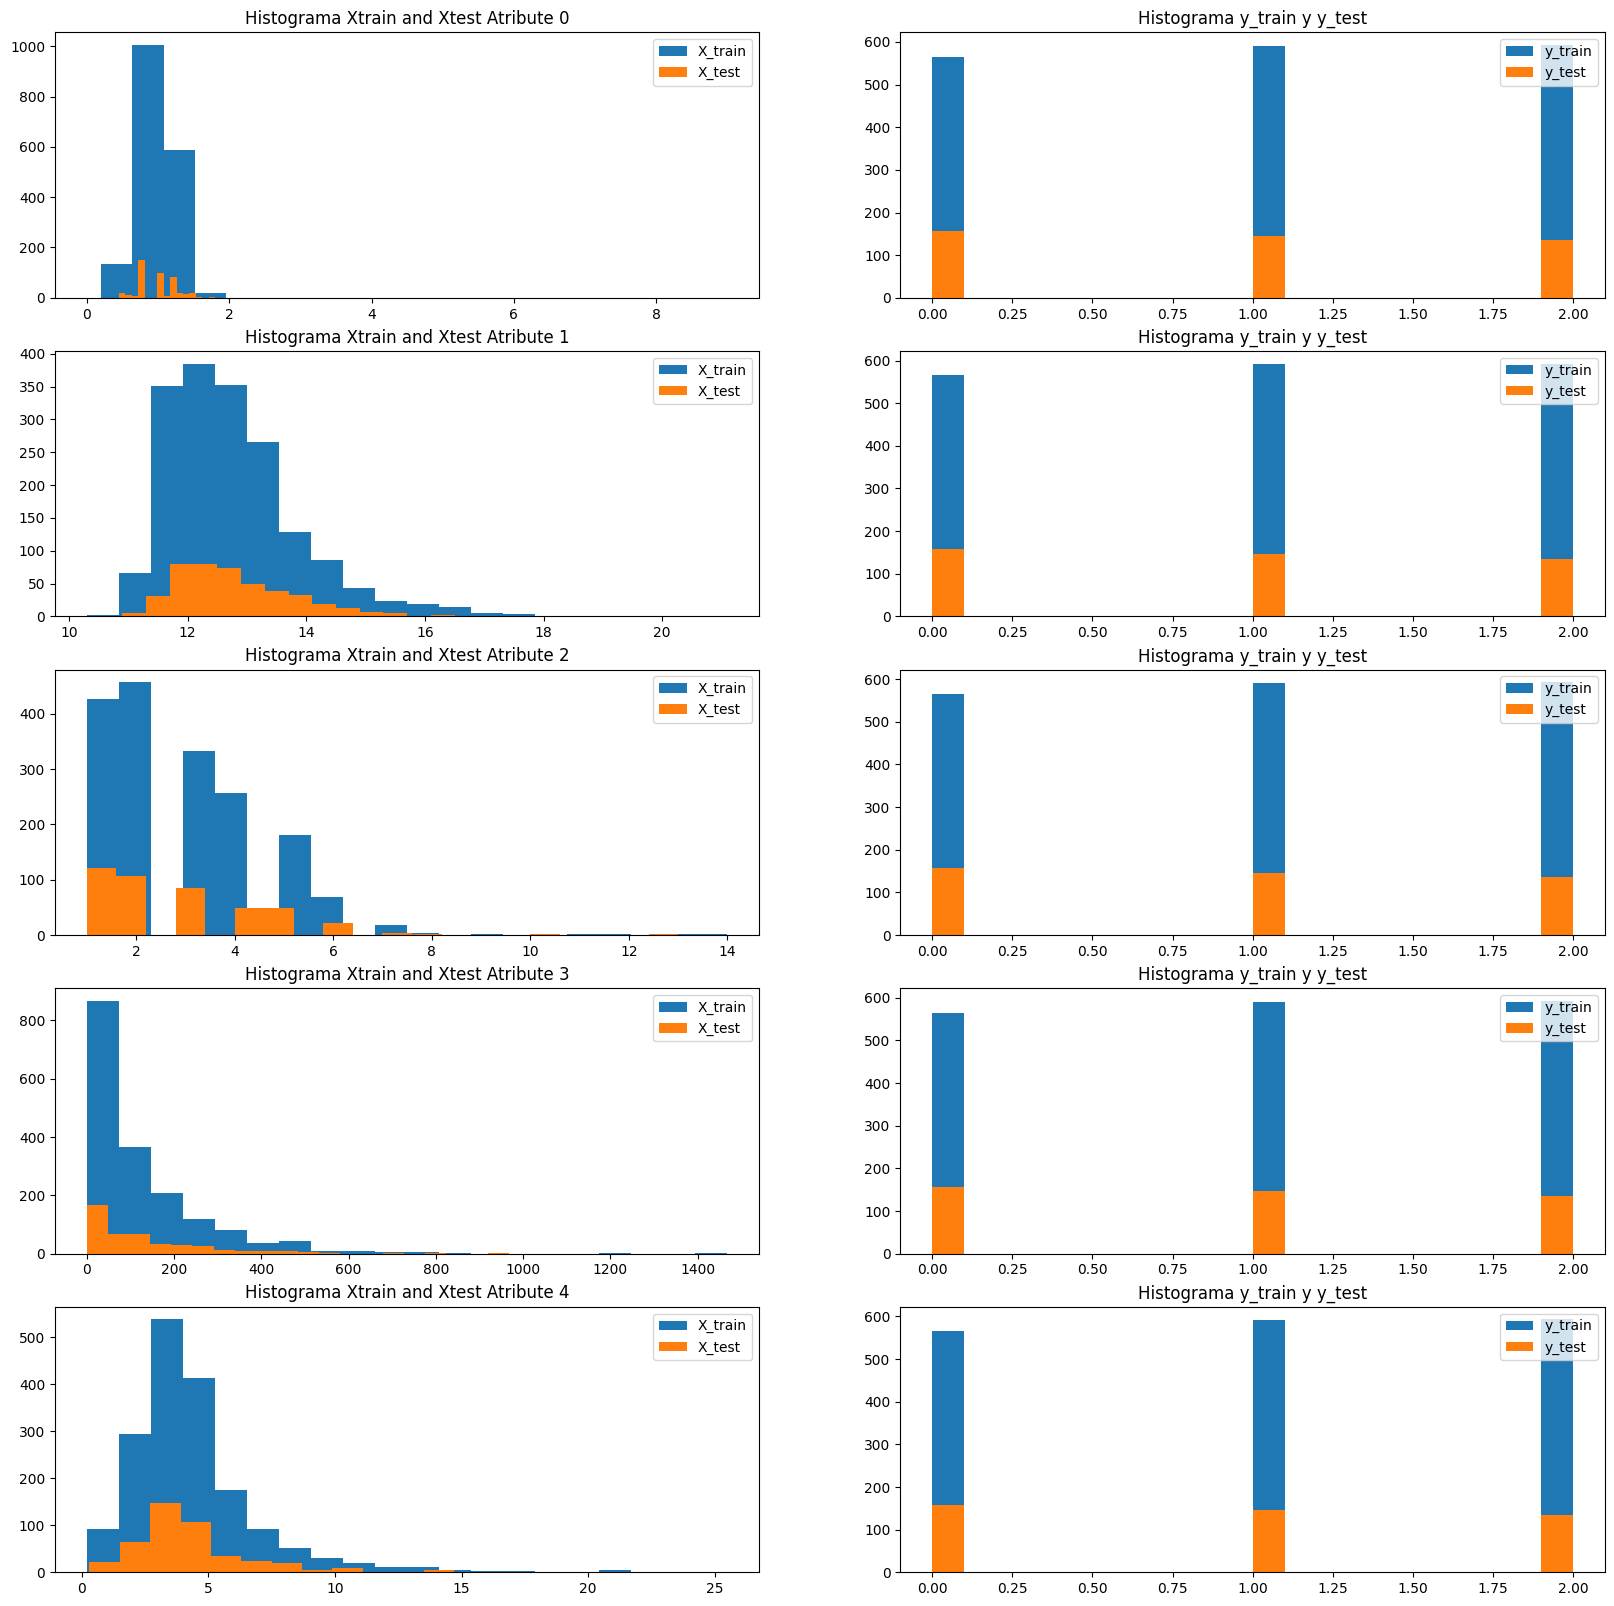

In [29]:
## Vamos a ver la distribución del predictor con respecto a la variable objetivo
row, col = X_train.shape

fig, axs = plt.subplots(col, 2, figsize=(20, 20))

if (col==1):
    axs[0].hist(X_train[:,0],bins = 20,label='X_train')
    axs[0].hist(X_test[:,0],bins = 20,label='X_test')
    axs[0].set_title('Histograma Xtrain and Xtest Atribute ' + str(1))
    axs[0].legend()

    axs[1].hist(y_train,bins = 20,label='y_train')
    axs[1].hist(y_test,bins = 20,label='y_test')
    axs[1].set_title('Histograma y_train y y_test')
    axs[1].legend()
    plt.show()
else:
    for i in range(col):

        axs[i, 0].hist(X_train[:,i],bins = 20,label='X_train')
        axs[i, 0].hist(X_test[:,i],bins = 20,label='X_test')
        axs[i, 0].set_title('Histograma Xtrain and Xtest Atribute ' + str(i))
        axs[i,0].legend()

        axs[i, 1].hist(y_train,bins = 20,label='y_train')
        axs[i, 1].hist(y_test,bins = 20,label='y_test')
        axs[i, 1].set_title('Histograma y_train y y_test')
        axs[i,1].legend()

    plt.show()

In [30]:
import numpy as np # Ensure numpy is imported if not already

print('TRAINING SET')
# Use np.bincount to count occurrences of each non-negative integer in the array
# The unique values in y_train and y_test are 0, 1, and 2
train_counts = np.bincount(y_train)
print('Counts per class (0, 1, 2):', train_counts)
print('Total records:', len(y_train))

print('\nTEST SET')
test_counts = np.bincount(y_test)
print('Counts per class (0, 1, 2):', test_counts)
print('Total records:', len(y_test))

# You can calculate percentages per class if needed
# train_percentages = train_counts / len(y_train) * 100
# test_percentages = test_counts / len(y_test) * 100
# print('Percentages per class (0, 1, 2) in Train:', train_percentages)
# print('Percentages per class (0, 1, 2) in Test:', test_percentages)

TRAINING SET
Counts per class (0, 1, 2): [565 591 593]
Total records: 1749

TEST SET
Counts per class (0, 1, 2): [157 146 135]
Total records: 438


### Entrenar el modelo con los datos de entrenamiento


In [31]:
log_reg_1.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr', penalty='l1',
                   solver='saga')

In [32]:
# Podemos ver los hiperparámetros con los que se creó el modelo y también
# el valor de los parámetros después del entrenamiento
print(log_reg_1.get_params())
print('w0 =', log_reg_1.intercept_)
print('wn =', log_reg_1.coef_)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
w0 = [-0.00268287 -0.00306401 -0.0103813 ]
wn = [[-4.06708442e-03 -5.81700396e-02  1.18411845e-01  6.36397885e-04
  -9.70890243e-02]
 [-5.77653201e-03 -8.44221694e-02  6.17478502e-02 -3.78292249e-04
   6.27937963e-02]
 [-2.85285021e-03 -8.39143331e-03 -2.22570070e-01  1.78095555e-04
   1.14116387e-02]]


In [33]:
# Predicción de una clase de salida
y_pred_train = log_reg_1.predict(X_train)
y_pred_test = log_reg_1.predict(X_test)

# Predicción de una probabilidad de pertenecer a alguna de las clases
y_pred_train_proba = log_reg_1.predict_proba(X_train)
y_pred_test_proba = log_reg_1.predict_proba(X_test)

In [34]:
y_pred_test

array([0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 1, 1, 2, 1, 0, 2, 2, 2, 1, 1, 2,
       2, 1, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 2, 2, 1, 0, 0, 2, 1,
       2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 0, 2, 0, 2, 0, 1, 2, 0, 2,
       1, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2, 2, 0, 1, 2, 1, 1, 0, 1, 2,
       1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 0, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2,
       1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1,
       2, 0, 0, 0, 2, 1, 0, 1, 2, 0, 1, 2, 1, 1, 0, 2, 2, 2, 2, 0, 0, 0,
       0, 1, 1, 2, 1, 0, 0, 0, 1, 0, 2, 2, 1, 1, 0, 2, 1, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 1, 2, 2, 1, 1, 0, 1, 0, 2, 1, 1, 1, 2, 0, 2, 1, 2, 0, 2, 0, 2,
       1, 0, 2, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 1,
       0, 1, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 2, 0, 0, 1,
       2, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 1, 2,
       1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2,

Cada valor en este array (0, 1, o 2) representa el nivel de TCH predicho por el modelo para el registro correspondiente en el conjunto de prueba:

0: Predicción de nivel de TCH "Bajo".
1: Predicción de nivel de TCH "Medio".
2: Predicción de nivel de TCH "Alto".

In [35]:
y_pred_test_proba

array([[0.39423845, 0.37072535, 0.23503619],
       [0.33565231, 0.28947082, 0.37487686],
       [0.2444233 , 0.33939646, 0.41618024],
       ...,
       [0.32760195, 0.30862907, 0.36376899],
       [0.34415052, 0.29131064, 0.36453884],
       [0.39171069, 0.37303478, 0.23525453]])

Columna 0: Probabilidad predicha de que el registro pertenezca a la clase 0 (Nivel_TCH_Bajo).
Columna 1: Probabilidad predicha de que el registro pertenezca a la clase 1 (Nivel_TCH_Medio).
Columna 2: Probabilidad predicha de que el registro pertenezca a la clase 2 (Nivel_TCH_Alto).

Por ejemplo, la primera fila [0.39423471, 0.37073205, 0.23503323] significa que para el primer registro del conjunto de prueba, el modelo predice una probabilidad del 39.42% de ser 'Bajo', 37% de ser 'Medio', y 25.35% de ser 'Alto'. La clase predicha (y_pred_test en la celda anterior) para este registro sería la que tiene la probabilidad más alta, que en este caso es la clase 0 ('Bajo').

## Empleando regularización, analizar la importancia de las variables predictoras en el desempeño de la clasificación.


In [36]:
# Mostrar los coeficientes del modelo entrenado con regularización L1
# La magnitud de los coeficientes (valor absoluto) indica la importancia de la característica
# Coeficientes cercanos o iguales a cero sugieren que la característica fue penalizada por la regularización L1

print("Coeficientes del modelo (importancia de las variables) para cada clase (vs. referencia):")

# Get the unique classes from the training data to use as labels
unique_classes = np.unique(y_train)
print("Clases únicas en los datos de entrenamiento:", unique_classes)


# The shape of log_reg_1.coef_ should be (n_classes, n_features) for 'ovr'
# Iterate through the rows of the coefficient matrix
for i, class_label in enumerate(unique_classes):
    print(f"\nCoeficientes para predecir la clase {class_label}:")
    # Pair predictor names with their coefficients for this class
    coef_pairs = list(zip(predictors, log_reg_1.coef_[i]))
    # Sort by absolute value of coefficient to see most important features first
    coef_pairs_sorted = sorted(coef_pairs, key=lambda item: abs(item[1]), reverse=True)
    for predictor, coef in coef_pairs_sorted:
        print(f"  {predictor}: {coef:.4f}")

# Note: For 'ovr', the coefficients for class k are from the model distinguishing class k vs. all other classes.
# Features with coefficients close to 0 across all classes are likely less important overall according to L1 regularization.

Coeficientes del modelo (importancia de las variables) para cada clase (vs. referencia):
Clases únicas en los datos de entrenamiento: [0 1 2]

Coeficientes para predecir la clase 0:
  cortes: 0.1184
  pct_diatrea: -0.0971
  edad: -0.0582
  dosismad: -0.0041
  lluvias: 0.0006

Coeficientes para predecir la clase 1:
  edad: -0.0844
  pct_diatrea: 0.0628
  cortes: 0.0617
  dosismad: -0.0058
  lluvias: -0.0004

Coeficientes para predecir la clase 2:
  cortes: -0.2226
  pct_diatrea: 0.0114
  edad: -0.0084
  dosismad: -0.0029
  lluvias: 0.0002


### Análisis de Coeficientes con Regularización L1 (One-vs-Rest)

El modelo de **Regresión Logística con regularización L1** penaliza la suma de los valores absolutos de los coeficientes, lo que puede llevar algunos a cero.  
Esto permite identificar qué variables son realmente relevantes para la clasificación.  

- La **magnitud absoluta** de un coeficiente indica la influencia de la variable para distinguir una clase.  
- Coeficientes cercanos a **cero** sugieren que la variable fue considerada poco relevante por la regularización L1.  

#### Resultados por clase

##### Clase 0 (Bajo)
- **cortes** → mayor magnitud absoluta.  
- **pct_diatrea** → también relevante.  

Son las variables más importantes para diferenciar este nivel.


#### Clase 1 (Medio)
- **edad** → coeficiente destacado.  
- **pct_diatrea** → peso relevante.  
- **cortes** → importancia significativa.  

Estas tres variables tienen mayor peso en la clasificación del nivel Medio.



#### Clase 2 (Alto)
- **cortes** → domina claramente con la mayor magnitud absoluta.  
- Otras variables → coeficientes cercanos a cero, con influencia reducida.  

cortes es el factor determinante para diferenciar este nivel.


#### Conclusión General

- **cortes** se confirma como el predictor más **consistente e importante** en la clasificación de los niveles de TCH.  
- **pct_diatrea** y **edad** también muestran relevancia en ciertos niveles, aunque su influencia es menor y más específica.  
- El modelo L1 facilita la **selección de variables clave**, al reducir el impacto de predictores menos importantes.  

In [37]:
from sklearn.linear_model import LogisticRegression
import numpy as np # Ensure numpy is imported if not already

# --- Modelo con Regularización Ridge (L2) ---
print("--- Modelo con Regularización Ridge (L2) ---")
# L2 is the default penalty, but specifying it is clear
# 'lbfgs' is the default solver, compatible with L2
log_reg_ridge = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, multi_class='ovr')

# Fit the Ridge model
log_reg_ridge.fit(X_train, y_train)

# Show the coefficients for Ridge model
print("\nCoeficientes del modelo Ridge para cada clase (vs. referencia):")
unique_classes = np.unique(y_train)

for i, class_label in enumerate(unique_classes):
    print(f"\nCoeficientes Ridge para predecir la clase {class_label}:")
    coef_pairs = list(zip(predictors, log_reg_ridge.coef_[i]))
    coef_pairs_sorted = sorted(coef_pairs, key=lambda item: abs(item[1]), reverse=True)
    for predictor, coef in coef_pairs_sorted:
        print(f"  {predictor}: {coef:.4f}")


# --- Modelo con Regularización Elastic Net ---
print("\n\n--- Modelo con Regularización Elastic Net ---")
# Elastic Net requires a compatible solver like 'saga'
# l1_ratio mixes L1 and L2 penalties (0 for pure L2, 1 for pure L1, 0.5 for equal mix)
log_reg_elasticnet = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, max_iter=1000, multi_class='ovr')

# Fit the Elastic Net model
log_reg_elasticnet.fit(X_train, y_train)

# Show the coefficients for Elastic Net model
print("\nCoeficientes del modelo Elastic Net para cada clase (vs. referencia):")

for i, class_label in enumerate(unique_classes):
    print(f"\nCoeficientes Elastic Net para predecir la clase {class_label}:")
    coef_pairs = list(zip(predictors, log_reg_elasticnet.coef_[i]))
    coef_pairs_sorted = sorted(coef_pairs, key=lambda item: abs(item[1]), reverse=True)
    for predictor, coef in coef_pairs_sorted:
        print(f"  {predictor}: {coef:.4f}")

# Note: Compare coefficient magnitudes across the three models (L1, Ridge, Elastic Net)
# L1 and Elastic Net (with l1_ratio > 0) can result in zero coefficients.
# Ridge shrinks coefficients but rarely to exactly zero.

--- Modelo con Regularización Ridge (L2) ---

Coeficientes del modelo Ridge para cada clase (vs. referencia):

Coeficientes Ridge para predecir la clase 0:
  cortes: 0.1979
  pct_diatrea: -0.1132
  dosismad: -0.0729
  edad: -0.0675
  lluvias: 0.0008

Coeficientes Ridge para predecir la clase 1:
  edad: -0.1944
  dosismad: -0.1145
  cortes: 0.0927
  pct_diatrea: 0.0751
  lluvias: 0.0001

Coeficientes Ridge para predecir la clase 2:
  cortes: -0.3442
  edad: 0.2225
  dosismad: 0.1602
  pct_diatrea: 0.0078
  lluvias: -0.0008


--- Modelo con Regularización Elastic Net ---

Coeficientes del modelo Elastic Net para cada clase (vs. referencia):

Coeficientes Elastic Net para predecir la clase 0:
  cortes: 0.1187
  pct_diatrea: -0.0973
  edad: -0.0582
  dosismad: -0.0045
  lluvias: 0.0006

Coeficientes Elastic Net para predecir la clase 1:
  edad: -0.0845
  pct_diatrea: 0.0630
  cortes: 0.0621
  dosismad: -0.0062
  lluvias: -0.0004

Coeficientes Elastic Net para predecir la clase 2:
  cortes:

### Análisis de Coeficientes con Regularización


#### Ridge (L2)

La **Regresión Logística con regularización Ridge (L2)** penaliza la **suma de los cuadrados de los coeficientes**, reduciendo su magnitud pero sin llevarlos a cero.  

#### Resultados por clase

- **Clase 0 (Bajo)**  
  - cortes: 0.1979  
  - pct_diatrea: -0.1132  
  - dosismad: -0.0729  
  - edad: -0.0675  
  Estos predictores tienen la mayor magnitud absoluta, por lo que son los más relevantes en esta clasificación.  

- **Clase 1 (Medio)**  
  - edad: -0.1944  
  - dosismad: -0.1145  
  - cortes: 0.0927  
  - pct_diatrea: 0.0751  

- **Clase 2 (Alto)**  
  - cortes: -0.3442 (dominante)  
  - edad: 0.2225  
  - dosismad: 0.1602  
  - pct_diatrea / lluvias: impacto lineal muy bajo  

**Conclusión Ridge:** Mantiene todas las variables en el modelo, pero asigna pesos diferenciados según su importancia relativa.


#### Elastic Net (L1 + L2, l1_ratio = 0.5)

La **Regresión Logística con Elastic Net** combina las penalizaciones **L1** y **L2**:  
- L2 reduce coeficientes.  
- L1 puede llevarlos a cero, descartando variables irrelevantes.  

#### Resultados por clase

- **Clase 0 (Bajo)**  
  - cortes: 0.1187  
  - pct_diatrea: -0.0972  
  - edad: -0.0582  
  - dosismad / lluvias: ≈ 0 → descartadas  

- **Clase 1 (Medio)**  
  - edad: -0.0845  
  - pct_diatrea: 0.0630  
  - cortes: 0.0621  

- **Clase 2 (Alto)**  
  - cortes: -0.2228 (principal)  
  - Resto de predictores: coeficientes muy pequeños  

**Conclusión Elastic Net:** Identifica a cortes como el predictor más crucial, reduciendo el peso de variables menos relevantes hasta casi eliminarlas.


#### Conclusión Global

- **Ridge (L2):** conserva todas las variables, mostrando su contribución relativa.  
- **Elastic Net (L1+L2):** resalta con mayor claridad a cortes como predictor clave, descartando variables de bajo impacto.  

Estos hallazgos orientan la selección de predictores y destacan la importancia de usar regularización en modelos multiclase para mejorar interpretabilidad y estabilidad.

### Comparación de Modelos con Regularización (L1, L2, Elastic Net)

Los tres tipos de regularización buscan **penalizar los coeficientes** para evitar el sobreajuste, pero lo hacen de manera distinta.  
Esto influye en qué variables se consideran más importantes (mantienen coeficientes de mayor magnitud) o se reducen a cero.  


#### 1. Consistencia en Predictores Clave
- En los tres modelos, **cortes** emerge como el predictor más importante.  
- Su **coeficiente negativo** indica consistentemente que un mayor número de cortes está asociado con **menor probabilidad de rendimiento Alto** en TCH.  
- También es relevante para los niveles **Bajo** y **Medio**, aunque con magnitudes variables.  


#### 2. Diferencias en el Peso de Otros Predictores
- **L1 y Elastic Net (l1_ratio=0.5):**  
  - Tienden a producir coeficientes más dispersos.  
  - Llevan algunos a **cero o casi cero**.  
  - Variables afectadas: **dosismad, lluvias, edad, pct_diatrea** en la predicción del nivel Alto.  
  - Actúan como **selectores de variables**, eliminando predictores menos informativos cuando cortes ya está incluido.  

- **Ridge (L2):**  
  - Encoge todos los coeficientes, pero rara vez los lleva a cero.  
  - Variables como **dosismad** y **edad** mantienen magnitudes más notables en los niveles Medio y Alto.  
  - Considera que estas variables aún aportan información, aunque con menor contribución.  


#### 3. Importancia Específica por Nivel
- **pct_diatrea y edad** → importantes para **niveles Bajo y Medio** (la magnitud depende del modelo).  
- **cortes** → crucial para el **nivel Alto**, de manera consistente en los tres métodos.  


#### 4. Conclusión Comparativa
- **cortes** es el predictor más **robusto y consistente** para clasificar los niveles de TCH, especialmente para identificar el rendimiento Alto.  
- **L1 y Elastic Net:**  
  - Favorecen la interpretabilidad.  
  - Eliminan o reducen a cero predictores menos relevantes.  
- **Ridge (L2):**  
  - Mantiene todas las variables con coeficientes reducidos.  
  - Útil cuando se prefiere conservar más información.  

La elección del modelo final dependerá de:  
- Métricas de rendimiento en conjunto de prueba o validación cruzada.  
- Necesidad de un modelo **más interpretable** (L1/Elastic Net) vs. uno **más inclusivo** (Ridge).  



#### Reflexión Final
Este análisis de coeficientes es una excelente forma de entender qué variables son linealmente más influyentes en cada clasificación bajo diferentes tipos de regularización.  

## Validación y Evaluación para el Modelo de Regresión Logistica para Nivel_TCH:



### Emplear una estrategia de validación (por ejemplo, validación cruzada) y justificar la elección.

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Se particionan los datos usando Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# stratified k-fold cross-validation
n_splits = 5
skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
model = LogisticRegression()

scoring = "accuracy"
scores = cross_val_score(model, X_train, y_train, cv=skfold, scoring=scoring)

# Print the output.
print(f"List of possible {scoring} that can be obtained from this model:")
formatted_strings = [f"{value:.4f}" for value in scores]
print(" ".join(formatted_strings))
print(f"\nMaximum {scoring}: {np.max(scores)*100:.4f} %")
print(f"\nMinimum {scoring}: {np.min(scores)*100:.4f} %")
print(f"\nAverage {scoring}: {np.mean(scores)*100:.4f} %")
print(f"\nStandard Deviation is: {np.std(scores)*100:.4f} %")

List of possible accuracy that can be obtained from this model:
0.4200 0.4857 0.4229 0.4543 0.4556

Maximum accuracy: 48.5714 %

Minimum accuracy: 42.0000 %

Average accuracy: 44.7689 %

Standard Deviation is: 2.4229 %


### GridSearch para analizar


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Se particionan los datos usando Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a dictionary of all values we want to test
param_grid = {'class_weight': ['balanced', None],
             'solver': ['lbfgs', 'liblinear', 'newton-cg']}

n_splits = 5
skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

model = LogisticRegression()

#use gridsearch to test all values
scoring = 'accuracy'
model_gscv = GridSearchCV(model, param_grid, cv=skfold, scoring=scoring)

#fit model to data
model_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'class_weight': ['balanced', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg']},
             scoring='accuracy')

In [40]:
model_best = model_gscv.best_estimator_
print(model_best.get_params())
print('w0 =', model_best.intercept_)
print('wn =', model_best.coef_)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
w0 = [-0.25847961  0.81783356 -1.78430697]
wn = [[-5.06231510e-02 -5.42945526e-02  2.27932355e-01  4.06388204e-04
  -9.33358942e-02]
 [-5.53604840e-02 -1.36135226e-01  5.74883752e-02 -7.22583824e-05
   3.80821242e-02]
 [ 8.91541769e-02  1.38447638e-01 -3.62113385e-01 -2.11315644e-04
   3.36395040e-02]]


In [41]:
from sklearn import metrics

y_pred_train = model_best.predict(X_train)
y_pred_test = model_best.predict(X_test)
print(metrics.classification_report(y_train,y_pred_train))
print(metrics.classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.45      0.49      0.47       587
           1       0.44      0.27      0.34       601
           2       0.47      0.61      0.53       561

    accuracy                           0.46      1749
   macro avg       0.45      0.46      0.45      1749
weighted avg       0.45      0.46      0.45      1749

              precision    recall  f1-score   support

           0       0.38      0.44      0.41       135
           1       0.39      0.29      0.33       136
           2       0.52      0.56      0.54       167

    accuracy                           0.44       438
   macro avg       0.43      0.43      0.43       438
weighted avg       0.44      0.44      0.44       438



### Evaluación el Modelo en Conjunto de Entrenamiento

In [42]:
y_pred_train = log_reg_1.predict(X_train)
y_pred_train_proba = log_reg_1.predict_proba(X_train)

In [43]:
y_pred_train

array([0, 2, 2, ..., 1, 0, 1])

In [44]:
y_pred_train_proba

array([[0.43536386, 0.36779287, 0.19684327],
       [0.31738061, 0.31527751, 0.36734187],
       [0.29541785, 0.33000501, 0.37457714],
       ...,
       [0.31282205, 0.34864451, 0.33853344],
       [0.41305326, 0.35000399, 0.23694274],
       [0.33191641, 0.34111799, 0.3269656 ]])

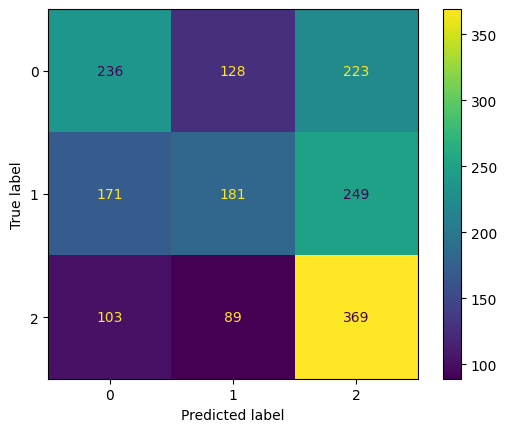

In [45]:
# Evaluación en el conjunto de entrenamiento
from sklearn import metrics

cm = metrics.confusion_matrix(y_train,y_pred_train)  #Una matriz de confusión para todas las categorías.
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [46]:
from sklearn import metrics

print(metrics.classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       0.46      0.40      0.43       587
           1       0.45      0.30      0.36       601
           2       0.44      0.66      0.53       561

    accuracy                           0.45      1749
   macro avg       0.45      0.45      0.44      1749
weighted avg       0.45      0.45      0.44      1749



### Evaluar el modelo en el conjunto de prueba

In [47]:
y_pred_test = log_reg_1.predict(X_test)
y_pred_test_proba = log_reg_1.predict_proba(X_test)

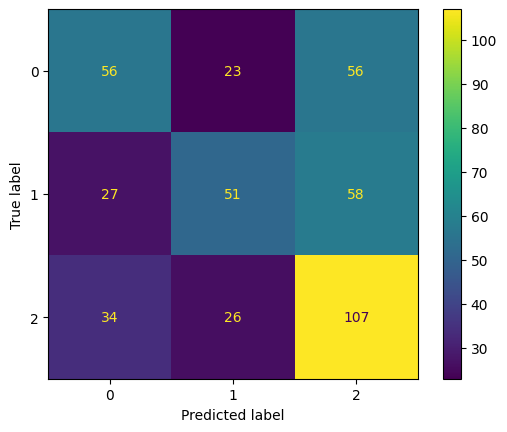

In [48]:
# Evaluación en el conjunto de entrenamiento
from sklearn import metrics

cm = metrics.confusion_matrix(y_test,y_pred_test)  #Una matriz de confusión para todas las categorías.
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [49]:
from sklearn import metrics

print(metrics.classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.48      0.41      0.44       135
           1       0.51      0.38      0.43       136
           2       0.48      0.64      0.55       167

    accuracy                           0.49       438
   macro avg       0.49      0.48      0.48       438
weighted avg       0.49      0.49      0.48       438



### Métricas de Clasificación por Clase y Globales

#### Clase 0 (Support: 135)
- **Precision: 0.48**  
  Cuando el modelo predice esta clase, acierta el 48% de las veces.  
- **Recall: 0.41**  
  Identifica correctamente el 41% de todas las instancias que realmente pertenecen a esta clase.  
- **F1-score: 0.44**  
  Representa un equilibrio moderado entre precisión y recall.  

#### Clase 1 (Support: 136)
- **Precision: 0.51**  
  Es la precisión más alta; cuando predice esta clase, acierta el 51% de las veces.  
- **Recall: 0.38**  
  Es el recall más bajo; solo identifica el 38% de las instancias reales de esta clase.  
- **F1-score: 0.43**  
  Moderado, limitado por el bajo recall.  

#### Clase 2 (Support: 167)
- **Precision: 0.48**  
  Similar a la Clase 0.  
- **Recall: 0.64**  
  Es el recall más alto; identifica el 64% de las instancias reales de esta clase.  
- **F1-score: 0.55**  
  Es el F1-score más alto, impulsado principalmente por el buen recall.  
- Es la clase con mayor número de instancias en el conjunto de prueba.  

#### Métricas Globales
- **Accuracy: 0.49**  
  El 49% de todas las instancias en el conjunto de prueba fueron clasificadas correctamente. Rendimiento general moderado.  

- **Macro Avg**  
  - Precision: 0.49  
  - Recall: 0.48  
  - F1-score: 0.48  
  Promedio no ponderado del rendimiento en las tres clases. Indica un rendimiento promedio moderado y relativamente equilibrado, sin considerar el tamaño de cada clase.  

- **Weighted Avg**  
  - Precision: 0.49  
  - Recall: 0.49  
  - F1-score: 0.48  
  Promedio ponderado por el número de instancias en cada clase. Similar al macro promedio, aunque ligeramente influenciado por la clase más grande (Clase 2).  

#### Conclusión
El modelo presenta un rendimiento general moderado, con una precisión global del 49%.  
- Se desempeña mejor en la **Clase 2**, gracias a su mayor recall y F1-score.  
- Tiene más dificultades para identificar las **Clases 0 y 1**, debido a recalls más bajos.  
- La precisión es similar en las Clases 0 y 2, y ligeramente mejor en la Clase 1.  
- Las métricas globales reflejan estas diferencias, confirmando un rendimiento moderado pero con mejor identificación de la Clase 2.  

### Reportar y analizar métricas de evaluación para clasificación (accuracy, precision, recall, F1-score, kappa.).


In [50]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np # Asegúrate de que numpy esté importado

def curva_roc(y_true, y_prob, title="Curva ROC"):
    """
    Calcula y grafica la curva ROC para un problema de clasificación (binaria o multi-clase).

    Args:
        y_true (array-like): Etiquetas verdaderas.
        y_prob (array-like): Probabilidades predichas para las clases.
                            En binario, puede ser 1D (prob. de la clase positiva) o 2D.
                            En multi-clase, debe ser 2D (prob. para cada clase).
        title (str): Título del gráfico.

    Returns:
        None
    """

    unique_classes = np.unique(y_true)
    n_classes = len(unique_classes)

    plt.figure(figsize=(8, 6))

    if n_classes == 2:
        print("Calculando ROC AUC para problema binario...")
        # Asegurarse de tener las probabilidades de la clase positiva para binario
        if y_prob.ndim == 2:
            # Asumiendo que la clase positiva es la que tiene el índice 1 después de ordenar
            # Si tus etiquetas no son 0 y 1, o si el orden importa, ajusta esto.
             if np.unique(y_true).tolist() == [0, 1]:
                 y_pos_prob = y_prob[:, 1]
             else:
                 print("Warning: Binary ROC AUC assumes labels 0 and 1 for y_true.")
                 # Intentar usar LabelEncoder si las etiquetas no son 0/1
                 from sklearn.preprocessing import LabelEncoder
                 le = LabelEncoder().fit(y_true)
                 y_true_binary = le.transform(y_true)
                 # Asegurarse que y_prob corresponde al orden de clases del encoder
                 # Esto puede ser complicado si las columnas de y_prob no están ordenadas
                 # según el LabelEncoder. Si tienes problemas, verifica el orden de y_prob.
                 if len(le.classes_) == 2:
                     y_pos_prob = y_prob[:, le.transform([le.classes_[1]])[0]]
                     y_true = y_true_binary
                 else:
                     print("Error: Could not determine positive class probability for binary ROC.")
                     return # Exit function if binary mapping fails
        elif y_prob.ndim == 1:
            y_pos_prob = y_prob # Asume que y_prob es la prob. de la clase positiva
            print("Warning: Assuming y_prob is probability of positive class in 1D array.")
        else:
            print("Error: y_prob has unexpected shape for binary ROC AUC.")
            return # Exit if shape is wrong

        # Calcular ROC AUC
        try:
            auc = roc_auc_score(y_true, y_pos_prob)
            print(f'AUC: {auc:.4f}')
            # Calcular curva ROC
            fpr, tpr, ths = roc_curve(y_true, y_pos_prob)
            plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.3f})')
        except Exception as e:
             print(f"Error calculating ROC AUC or curve: {e}")
             # Si hay un error (ej. solo una clase presente), intentar trazar solo la línea base
             plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Azar')
             print("Could not calculate ROC curve. Plotting random chance line.")


    elif n_classes > 2:
        print(f"Calculando ROC AUC (multi_class='ovr') para {n_classes} clases...")
        # Calcular ROC AUC para multi-clase (ovr)
        try:
            # Utiliza multi_class='ovr' para problemas multiclase
            auc_ovr = roc_auc_score(y_true, y_prob, multi_class='ovr')
            print(f'AUC (OvR): {auc_ovr:.4f}')
             # No hay una única curva ROC para multi-clase, pero podemos graficar para cada clase vs Rest
            for i in range(n_classes):
                # Binarizar la etiqueta para la clase actual
                y_true_binary = (y_true == unique_classes[i]).astype(int)
                # Probabilidades de la clase actual
                y_prob_class = y_prob[:, i]

                # Calcular curva ROC para la clase actual vs Rest
                fpr, tpr, _ = roc_curve(y_true_binary, y_prob_class)
                plt.plot(fpr, tpr, label=f'Clase {unique_classes[i]} vs Rest (AUC = {roc_auc_score(y_true_binary, y_prob_class):.3f})')

        except Exception as e:
            print(f"Error calculating multi-class ROC AUC or curves: {e}")
            # Si hay un error, intentar trazar solo la línea base
            plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Azar')
            print("Could not calculate multi-class ROC curves. Plotting random chance line.")


    else:
        print("Error: Number of unique classes must be at least 2 for ROC AUC calculation.")
        return # Exit if less than 2 classes

    # Graficar la línea de azar
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Azar')

    # Etiquetas y título
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

TRAINING SET
Calculando ROC AUC (multi_class='ovr') para 3 clases...
AUC (OvR): 0.6209


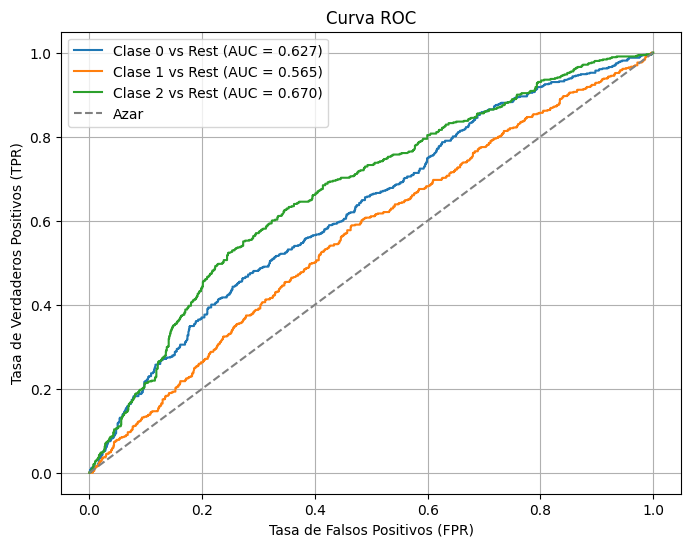

In [51]:
print("TRAINING SET")
ths = curva_roc(y_train, y_pred_train_proba)

TEST SET
Calculando ROC AUC (multi_class='ovr') para 3 clases...
AUC (OvR): 0.6263


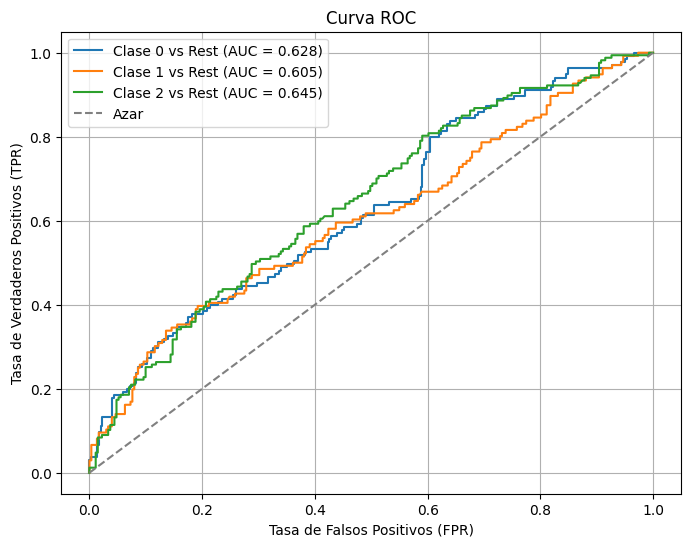

In [52]:
print("TEST SET")
ths = curva_roc(y_test, y_pred_test_proba)

In [53]:
# Utilidades de evaluación (formato consistente con los talleres previos)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score

def eval_classifier_report(y_true, y_pred, y_proba=None, title_prefix=""):
    cm = metrics.confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión {title_prefix}")
    plt.show()

    acc = metrics.accuracy_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = metrics.recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = metrics.f1_score(y_true, y_pred, average='macro', zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1-score (macro): {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    if y_proba is not None and len(np.unique(y_true)) == 2:
        from sklearn.metrics import roc_auc_score, roc_curve
        # Asumimos que y_proba es la prob. de la clase positiva en binario
        if y_proba.ndim == 2 and y_proba.shape[1] == 2:
            y_pos = y_proba[:, 1]
            auc = roc_auc_score(y_true, y_pos)
            print(f"ROC-AUC: {auc:.4f}")
            fpr, tpr, _ = roc_curve(y_true, y_pos)
            plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
            plt.plot([0,1], [0,1], linestyle='--', color='gray')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend()
            plt.title(f"Curva ROC {title_prefix}")
            plt.show()

    return {"accuracy": acc, "precision_macro": prec, "recall_macro": rec, "f1_macro": f1, "kappa": kappa}



Evaluación del modelo log_reg_1 en el conjunto de prueba:


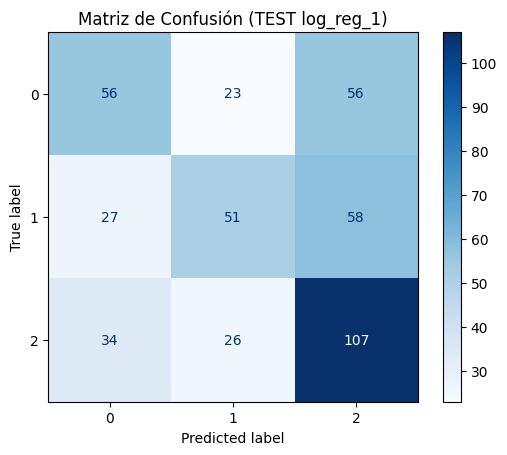

Accuracy: 0.4886
Precision (macro): 0.4909
Recall (macro): 0.4768
F1-score (macro): 0.4761
Cohen's Kappa: 0.2185


In [54]:
# Reportar y analizar métricas de evaluación para clasificación (accuracy, precision, recall, F1-score, kappa.)
# Evaluar el modelo log_reg_1 en el conjunto de prueba

print("Evaluación del modelo log_reg_1 en el conjunto de prueba:")
metrics_test_log_reg_1 = eval_classifier_report(y_test, y_pred_test, y_proba=y_pred_test_proba, title_prefix="(TEST log_reg_1)")

### Resultados del Modelo de Regresión Logística (L1, One-vs-Rest)

Parámetros del modelo:  
`solver='saga'`, `penalty='l1'`, `max_iter=1000`, `multi_class='ovr'`


#### Métricas Globales en el Conjunto de Prueba

- **Accuracy: 0.4886 (~49%)**  
  Aproximadamente el 49% de las instancias fueron clasificadas correctamente.  
  Este valor indica un rendimiento general **moderado**, apenas por debajo del 50%.

- **Precision (macro): 0.4909 (~49%)**  
  La precisión promedio entre clases es de ~49%.  
  En promedio, cuando el modelo predice una clase, hay casi un **50% de probabilidad** de que sea la correcta.

- **Recall (macro): 0.4768 (~48%)**  
  El recall promedio es cercano al 48%.  
  Esto significa que el modelo logra identificar correctamente **casi la mitad de las instancias de cada clase**.

- **F1-score (macro): 0.4761 (~48%)**  
  Combina precisión y recall.  
  Confirma un rendimiento promedio **moderado**, equilibrando la capacidad de no cometer falsos positivos y de encontrar verdaderos positivos.

- **Cohen’s Kappa: 0.2185**  
  - Indica un **acuerdo débil** entre las predicciones del modelo y las etiquetas reales.  
  - Valores cercanos a 0 reflejan acuerdo similar al azar.  
  - Valores cercanos a 1 reflejan acuerdo perfecto.  
  - Un valor de **0.2185** sugiere que el modelo clasifica **solo ligeramente mejor que el azar**.


#### Análisis Adicional (basado en métricas por clase previas)

Aunque en esta corrida no se presentan métricas detalladas por clase, de análisis previos sabemos que:

- **Clase "Alto":**  
  - Recall de aproximadamente **0.64**.  
  - El modelo es más efectivo identificando instancias de esta clase cuando están presentes.  

- **Clases "Bajo" y "Medio":**  
  - Recalls más bajos, alrededor de **0.41** y **0.38**, respectivamente.  
  - El modelo es **menos efectivo** en la identificación de estas clases.  

Esto sugiere un **sesgo relativo a favor de la clase "Alto"**, que además es la clase con más soporte en el conjunto de prueba.

#### Conclusión General

El modelo de **Regresión Logística con regularización L1** muestra un rendimiento general **modesto** en este problema de clasificación multiclase:

- Rendimiento cercano al **50% en precisión, recall y F1-score macro**.  
- Sin embargo, el bajo **Cohen’s Kappa (0.2185)** indica que la capacidad del modelo de clasificar correctamente está solo **ligeramente por encima del azar**.  
- El desempeño varía según la clase:  
  - Mejor en **"Alto"**.  
  - Más limitado en **"Bajo"** y **"Medio"**.  

En conjunto, el modelo necesita mejoras para lograr un rendimiento más balanceado y robusto en todas las clases.  

### Volvimos a hacer GridSearchCV, con el fin de verficar si en verdad da peores metricas que el modelo de regresion logistica de linea base

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

# 1. Definir el modelo base
model = LogisticRegression(random_state=42, max_iter=1000) # Puedes ajustar max_iter si es necesario

# 2. Definir la cuadrícula de parámetros a probar
# Aquí probaremos diferentes valores para C y diferentes tipos de penalización
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inversa de la fuerza de regularización
    'penalty': ['l1', 'l2'], # Tipo de regularización: L1 o L2
    'solver': ['liblinear', 'lbfgs'] # Incluir solvers compatibles con l1 y l2
}

# 3. Configurar la validación cruzada (por ejemplo, StratifiedKFold para problemas de clasificación)
# Usaremos StratifiedKFold ya que es un problema de clasificación y queremos mantener la proporción de clases
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Inicializar GridSearchCV
# scoring='accuracy' es una métrica común para clasificación. Puedes usar 'f1_macro', 'recall_macro', etc.
# n_jobs=-1 usa todos los núcleos disponibles para acelerar el proceso
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skfold, scoring='accuracy', n_jobs=-1)

# 5. Ajustar GridSearchCV a los datos de entrenamiento
# Esto ejecutará la búsqueda en la cuadrícula de parámetros usando validación cruzada
print("Iniciando GridSearchCV para Logistic Regression...")
grid_search.fit(X_train, y_train)

# 6. Mostrar los mejores parámetros encontrados y la mejor puntuación
print("\n--- Resultados de GridSearchCV ---")
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor puntuación (Accuracy en CV): {:.4f}".format(grid_search.best_score_))


Iniciando GridSearchCV para Logistic Regression...

--- Resultados de GridSearchCV ---
Mejores parámetros encontrados: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Mejor puntuación (Accuracy en CV): 0.4620



Métricas en el conjunto de prueba con el mejor modelo:


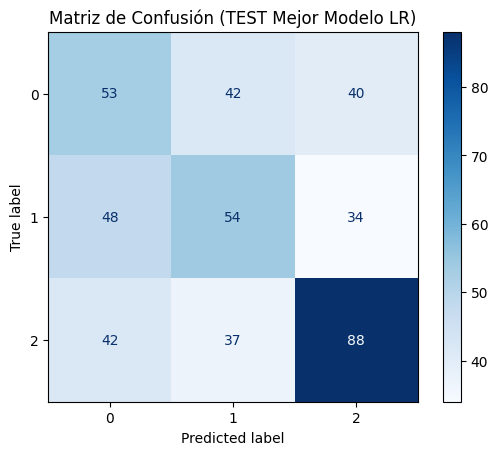

Accuracy: 0.4452
Precision (macro): 0.4400
Recall (macro): 0.4389
F1-score (macro): 0.4392
Cohen's Kappa: 0.1645


{'accuracy': 0.4452054794520548,
 'precision_macro': 0.43995142825552175,
 'recall_macro': 0.4388658413021451,
 'f1_macro': 0.4392454533903978,
 'kappa': np.float64(0.16454861574448376)}

In [56]:
# Puedes obtener el mejor modelo entrenado así:
best_model = grid_search.best_estimator_

# Y luego evaluar este best_model en X_test, y_test
y_pred_test_best = best_model.predict(X_test)
print("\nMétricas en el conjunto de prueba con el mejor modelo:")
eval_classifier_report(y_test, y_pred_test_best, title_prefix="(TEST Mejor Modelo LR)")

Nos damos cuenta que si usamos GridSearchCV, el model se comporta peor. Aca algunas razones:

El hecho de que un modelo optimizado con GridSearchCV muestre un rendimiento inferior al de una configuración manual es un fenómeno que puede atribuirse a varias causas potenciales, sin que se pueda señalar una con total certeza. Una de las posibilidades más comunes es un sobreajuste al conjunto de validación; al probar sistemáticamente numerosas combinaciones, es factible que GridSearchCV encuentre un conjunto de hiperparámetros que se ajuste excepcionalmente bien por pura casualidad a los subconjuntos de datos de la validación cruzada, pero que falle al generalizar ante datos completamente nuevos. Otra hipótesis es que el espacio de búsqueda (param_grid) definido no fuera el adecuado, quizás excluyendo los rangos de valores verdaderamente óptimos y forzando al algoritmo a elegir la "mejor opción" dentro de un conjunto de configuraciones subóptimas. Finalmente, no se puede descartar un error técnico sutil como la fuga de datos (data leakage), que podría ocurrir si pasos como la estandarización de los datos se aplicaron a todo el conjunto antes de la validación cruzada, lo que llevaría a una evaluación demasiado optimista del rendimiento durante la búsqueda.

## Desarrollo de Modelos de Clasificación con Regresión Logistica para Nivel_Sacarosa:


### Crear la variables para los predictores y para la variable objetivo

In [57]:
# y es la variable target
# X es el arreglo con los valores de los predictores

Sacarosa_target = 'Nivel_Sacarosa_num'
# Use the same predictors as the TCH model
Sacarosa_predictors = ['dosismad','edad','cortes','lluvias','pct_diatrea']

Sacarosa_y = df_bd_ipsa_1940_clean[Sacarosa_target].values
Sacarosa_X = df_bd_ipsa_1940_clean[Sacarosa_predictors].values

print(type(Sacarosa_y))
print(Sacarosa_y.shape)
print(type(Sacarosa_X))
print(Sacarosa_X.shape)

<class 'numpy.ndarray'>
(2187,)
<class 'numpy.ndarray'>
(2187, 5)


### Particionar los datos en: conjunto de entrenamiento, conjunto de validación (si se va a usar), conjunto de prueba.

En este caso, como lo vimos en clase solo vamos a utilizar conjunto de entrenamiento (80%) y conjunto de prueba (20%)

In [58]:
# Particionar los datos en: conjunto de entrenamiento y conjunto de prueba.
# La partición se realiza de forma aleatoria y se necesita una semilla para ello.
# Se utiliza la estratificación para mantener la proporción de clases en ambos conjuntos.

X_train_sac, X_test_sac, y_train_sac, y_test_sac = train_test_split(
    Sacarosa_X, Sacarosa_y, test_size=0.2, random_state=42, stratify=Sacarosa_y
)

# Imprimir las formas de los conjuntos resultantes para verificar la partición.
print("Forma del conjunto de entrenamiento de predictores (X_train_sac):", X_train_sac.shape)
print("Forma del conjunto de prueba de predictores (X_test_sac):", X_test_sac.shape)
print("Forma del conjunto de entrenamiento de la variable objetivo (y_train_sac):", y_train_sac.shape)
print("Forma del conjunto de prueba de la variable objetivo (y_test_sac):", y_test_sac.shape)

Forma del conjunto de entrenamiento de predictores (X_train_sac): (1749, 5)
Forma del conjunto de prueba de predictores (X_test_sac): (438, 5)
Forma del conjunto de entrenamiento de la variable objetivo (y_train_sac): (1749,)
Forma del conjunto de prueba de la variable objetivo (y_test_sac): (438,)


### Crear el modelo y entrenarlo con los datos de entrenamiento

En este paso es donde se ajustan los hiperparámetros

In [59]:
# Initialize a Logistic Regression model
# Setting random_state for reproducibility
# Increasing max_iter to ensure convergence if needed
log_reg_sacarosa = LogisticRegression(C=10, max_iter=1000, penalty='l1', random_state=42, solver='liblinear')

# Train the model using the training data
log_reg_sacarosa.fit(X_train_sac, y_train_sac)

# Print the learned coefficients and intercept
print('Intercept (w0) =', log_reg_sacarosa.intercept_)
print('Coefficients (wn) =', log_reg_sacarosa.coef_)

Intercept (w0) = [ 0.00372472  0.44602096 -2.39992666]
Coefficients (wn) = [[-0.14814397 -0.08046788 -0.02298327  0.00254214  0.06808614]
 [-0.05422761 -0.08059027  0.0252744  -0.00056012 -0.02509113]
 [ 0.19700219  0.15310626 -0.00120364 -0.00225223 -0.05055028]]


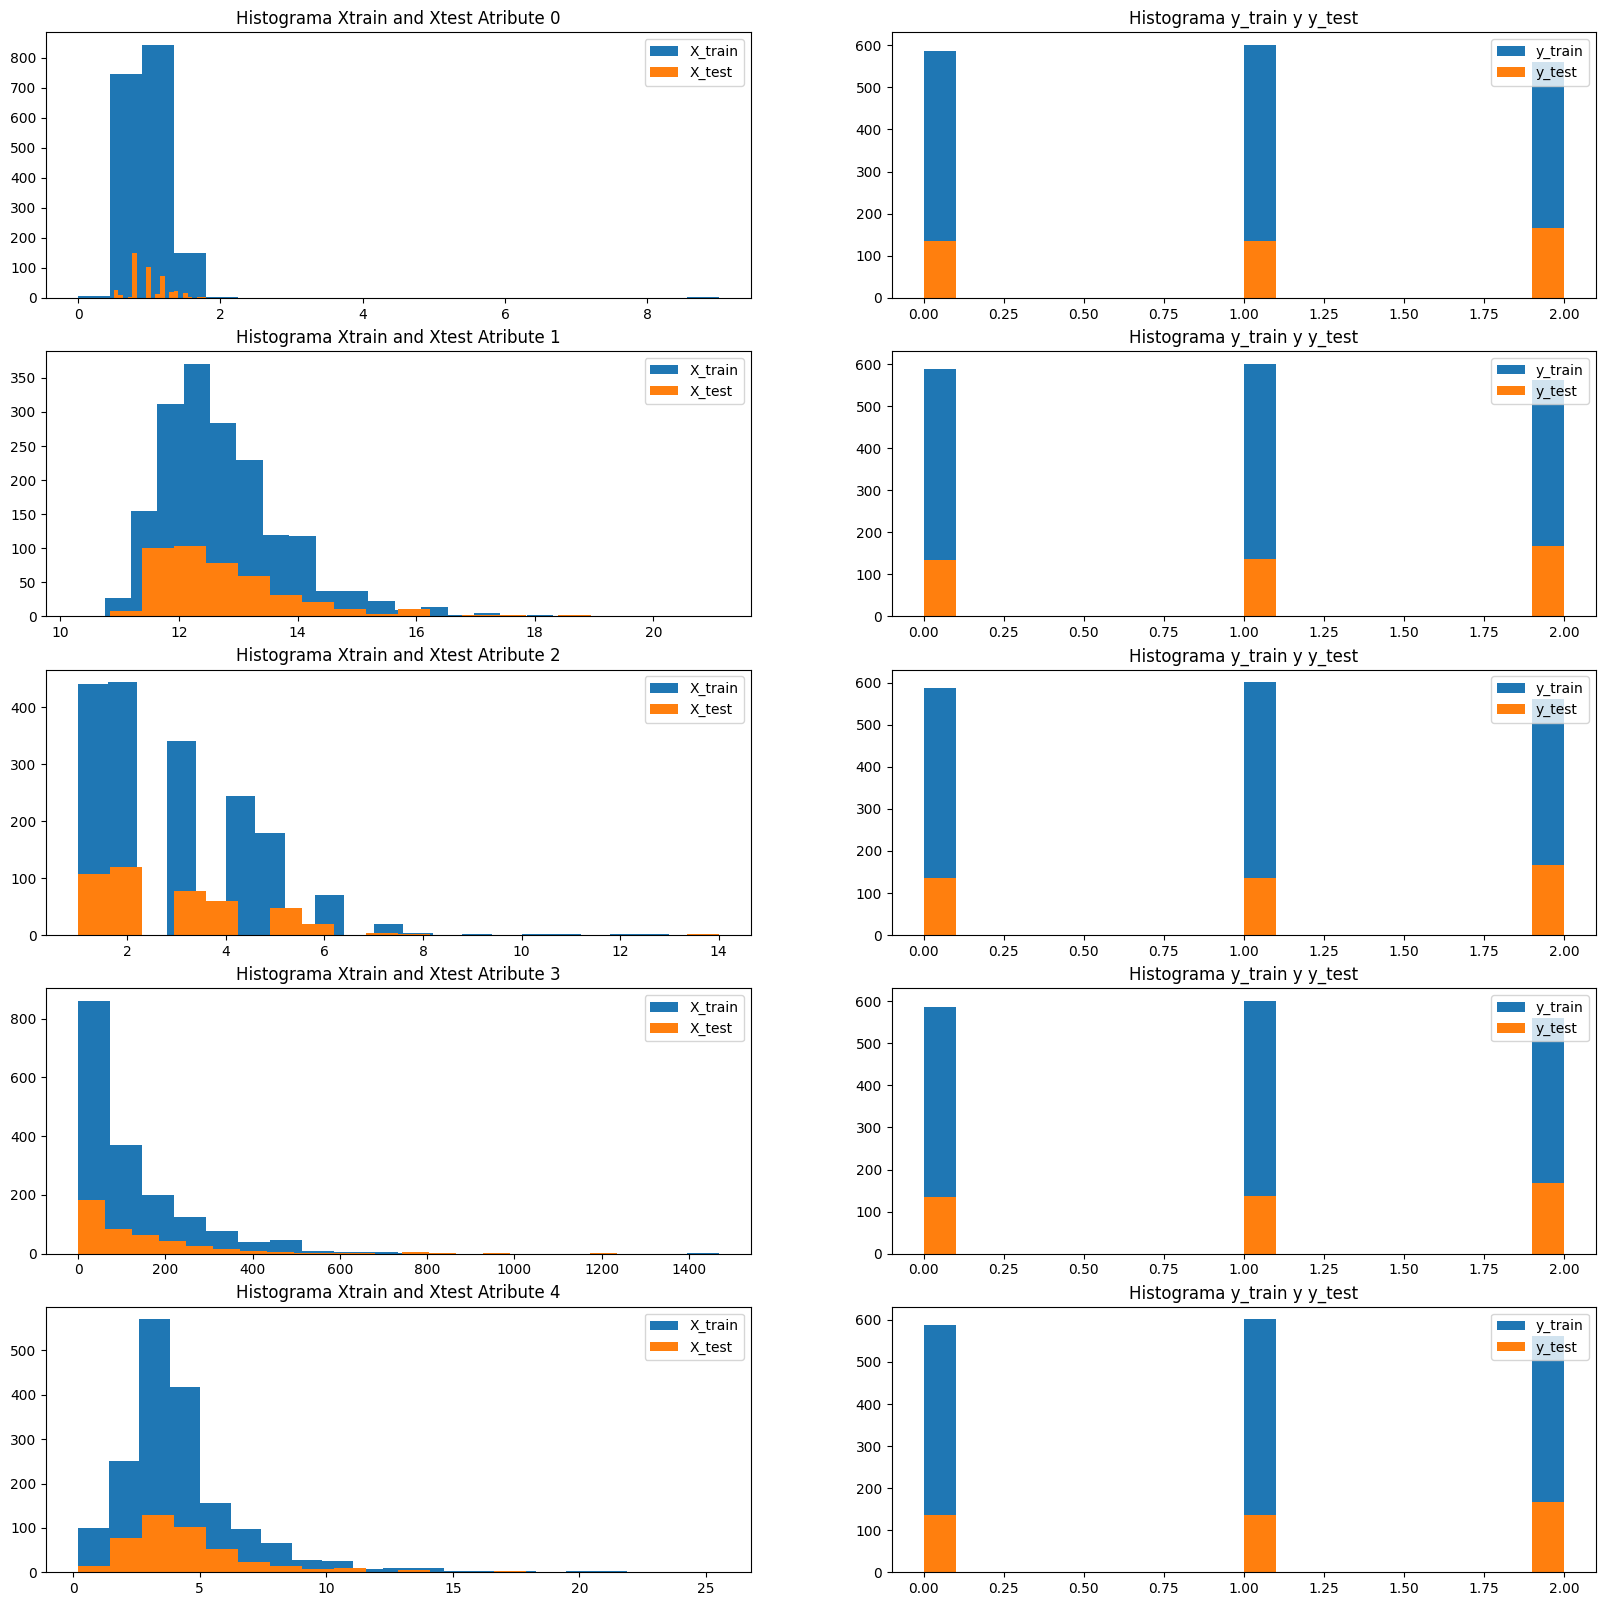

In [60]:
## Vamos a ver la distribución del predictor con respecto a la variable objetivo
row, col = X_train.shape

fig, axs = plt.subplots(col, 2, figsize=(20, 20))

if (col==1):
    axs[0].hist(X_train[:,0],bins = 20,label='X_train')
    axs[0].hist(X_test[:,0],bins = 20,label='X_test')
    axs[0].set_title('Histograma Xtrain and Xtest Atribute ' + str(1))
    axs[0].legend()

    axs[1].hist(y_train,bins = 20,label='y_train')
    axs[1].hist(y_test,bins = 20,label='y_test')
    axs[1].set_title('Histograma y_train y y_test')
    axs[1].legend()
    plt.show()
else:
    for i in range(col):

        axs[i, 0].hist(X_train[:,i],bins = 20,label='X_train')
        axs[i, 0].hist(X_test[:,i],bins = 20,label='X_test')
        axs[i, 0].set_title('Histograma Xtrain and Xtest Atribute ' + str(i))
        axs[i,0].legend()

        axs[i, 1].hist(y_train,bins = 20,label='y_train')
        axs[i, 1].hist(y_test,bins = 20,label='y_test')
        axs[i, 1].set_title('Histograma y_train y y_test')
        axs[i,1].legend()

    plt.show()

In [61]:
import numpy as np # Ensure numpy is imported if not already

print('TRAINING SET')
# Use np.bincount to count occurrences of each non-negative integer in the array
# The unique values in y_train and y_test are 0, 1, and 2
train_counts = np.bincount(y_train)
print('Counts per class (0, 1, 2):', train_counts)
print('Total records:', len(y_train))

print('\nTEST SET')
test_counts = np.bincount(y_test)
print('Counts per class (0, 1, 2):', test_counts)
print('Total records:', len(y_test))

# You can calculate percentages per class if needed
# train_percentages = train_counts / len(y_train) * 100
# test_percentages = test_counts / len(y_test) * 100
# print('Percentages per class (0, 1, 2) in Train:', train_percentages)
# print('Percentages per class (0, 1, 2) in Test:', test_percentages)

TRAINING SET
Counts per class (0, 1, 2): [587 601 561]
Total records: 1749

TEST SET
Counts per class (0, 1, 2): [135 136 167]
Total records: 438


In [62]:
# Predict the class labels for the training and test sets
y_pred_train_sacarosa = log_reg_sacarosa.predict(X_train_sac)
y_pred_test_sacarosa = log_reg_sacarosa.predict(X_test_sac)

# Predict the class probabilities for the training and test sets
y_pred_train_proba_sacarosa = log_reg_sacarosa.predict_proba(X_train_sac)
y_pred_test_proba_sacarosa = log_reg_sacarosa.predict_proba(X_test_sac)

# Display the predicted class labels for the test set
print("Predicted class labels for the test set (y_pred_test_sacarosa):")
print(y_pred_test_sacarosa)

# Display the predicted class probabilities for the test set
print("\nPredicted class probabilities for the test set (y_pred_test_proba_sacarosa):")
print(y_pred_test_proba_sacarosa)

Predicted class labels for the test set (y_pred_test_sacarosa):
[1 2 0 0 2 1 2 1 2 2 1 1 0 2 2 2 2 1 0 1 2 1 0 0 0 0 0 2 2 0 0 0 0 0 2 2 2
 0 1 0 2 0 0 0 2 1 2 0 2 2 0 1 2 1 2 0 0 0 2 0 0 1 1 2 0 2 0 2 0 0 2 2 2 2
 2 2 0 0 1 2 2 0 0 1 2 2 2 0 0 2 2 2 1 0 1 2 0 0 0 0 2 0 0 2 2 0 1 2 2 2 2
 0 1 2 2 0 0 0 1 1 1 0 0 1 2 0 0 1 2 0 1 1 0 2 0 1 0 0 2 0 2 1 2 0 0 2 0 0
 2 1 0 1 2 2 2 2 2 1 0 1 2 2 1 0 1 1 2 0 0 0 1 2 1 1 2 1 2 2 2 0 0 0 2 2 0
 2 1 0 0 2 1 2 0 1 2 1 0 2 1 2 0 2 0 0 0 2 1 0 0 1 0 0 2 0 1 2 2 0 2 0 0 0
 0 1 1 0 0 0 1 1 1 2 0 0 1 2 0 0 0 0 2 0 2 2 0 2 2 0 0 0 0 0 1 2 0 2 0 2 0
 0 0 0 2 0 1 2 2 1 0 1 1 2 0 0 2 2 0 0 0 2 1 0 0 0 2 2 2 0 2 2 2 0 1 0 2 0
 1 2 1 2 1 0 0 1 2 2 1 0 0 0 2 0 2 0 1 1 0 1 1 0 0 0 0 2 0 1 0 1 1 2 2 0 0
 1 0 2 1 0 0 2 1 0 0 0 2 0 2 2 0 0 2 1 1 0 0 2 1 0 0 1 0 0 2 1 2 0 0 2 0 1
 2 0 0 2 0 1 1 1 0 0 0 0 0 1 0 1 0 2 0 0 1 2 1 0 0 0 2 0 2 0 1 0 1 0 2 2 0
 2 2 0 0 1 0 2 0 1 0 0 0 0 2 0 2 2 0 0 0 0 1 0 0 1 0 2 0 1 2 2]

Predicted class probabilities for the test set

## Empleando regularización, analizar la importancia de las variables predictoras en el desempeño de la clasificación.


In [63]:
# Mostrar los coeficientes del modelo entrenado con regularización L1
# La magnitud de los coeficientes (valor absoluto) indica la importancia de la característica
# Coeficientes cercanos o iguales a cero sugieren que la característica fue penalizada por la regularización L1

print("Coeficientes del modelo (importancia de las variables) para cada clase (vs. referencia):")

# Get the unique classes from the training data to use as labels
unique_classes = np.unique(y_train)
print("Clases únicas en los datos de entrenamiento:", unique_classes)


# The shape of log_reg_1.coef_ should be (n_classes, n_features) for 'ovr'
# Iterate through the rows of the coefficient matrix
for i, class_label in enumerate(unique_classes):
    print(f"\nCoeficientes para predecir la clase {class_label}:")
    # Pair predictor names with their coefficients for this class
    coef_pairs = list(zip(predictors, log_reg_1.coef_[i]))
    # Sort by absolute value of coefficient to see most important features first
    coef_pairs_sorted = sorted(coef_pairs, key=lambda item: abs(item[1]), reverse=True)
    for predictor, coef in coef_pairs_sorted:
        print(f"  {predictor}: {coef:.4f}")

# Note: For 'ovr', the coefficients for class k are from the model distinguishing class k vs. all other classes.
# Features with coefficients close to 0 across all classes are likely less important overall according to L1 regularization.

Coeficientes del modelo (importancia de las variables) para cada clase (vs. referencia):
Clases únicas en los datos de entrenamiento: [0 1 2]

Coeficientes para predecir la clase 0:
  cortes: 0.1184
  pct_diatrea: -0.0971
  edad: -0.0582
  dosismad: -0.0041
  lluvias: 0.0006

Coeficientes para predecir la clase 1:
  edad: -0.0844
  pct_diatrea: 0.0628
  cortes: 0.0617
  dosismad: -0.0058
  lluvias: -0.0004

Coeficientes para predecir la clase 2:
  cortes: -0.2226
  pct_diatrea: 0.0114
  edad: -0.0084
  dosismad: -0.0029
  lluvias: 0.0002


### Análisis de Coeficientes con Regularización L1 (Nivel_Sacarosa_num)

La regularización **L1 en la Regresión Logística** penaliza los valores absolutos de los coeficientes, lo que puede llevar a que algunos se reduzcan a cero.  
Esto ayuda a identificar las características más importantes para cada clase.  
La magnitud del coeficiente indica la **fuerza de la relación**, y el signo (positivo o negativo) indica la **dirección**.

#### Clase 0 (Bajo - Sacarosa Baja)
- **cortes (0.1184):** Tiene el coeficiente positivo más grande. Sugiere que un mayor número de cortes está asociado con una mayor probabilidad de que el nivel de sacarosa sea "Bajo".  
- **pct_diatrea (-0.0971):** Coeficiente negativo notable. Indica que un mayor porcentaje de infestación por diatrea está asociado con una menor probabilidad de estar en el nivel "Bajo".  
- **edad (-0.0582):** Coeficiente negativo, lo que sugiere que cultivos más viejos tienen menos probabilidad de pertenecer al nivel "Bajo".  
- **dosismad (-0.0041) y lluvias (0.0006):** Coeficientes cercanos a cero. La regularización L1 ha reducido su importancia significativamente para esta clase.  

#### Clase 1 (Medio - Sacarosa Media)
- **edad (-0.0844):** Tiene el coeficiente absoluto más grande y es negativo. Sugiere que la edad del cultivo es un factor importante: cultivos más viejos tienen menor probabilidad de estar en el nivel "Medio".  
- **pct_diatrea (0.0628):** Coeficiente positivo. Un mayor porcentaje de diatrea aumenta la probabilidad de que el nivel sea "Medio".  
- **cortes (0.0617):** Coeficiente positivo. Un mayor número de cortes se asocia con una mayor probabilidad de estar en el nivel "Medio".  
- **dosismad (-0.0058) y lluvias (-0.0004):** Coeficientes muy cercanos a cero, indicando poca relevancia en la clasificación de este nivel.  

#### Clase 2 (Alto - Sacarosa Alta)
- **cortes (-0.2226):** Tiene el coeficiente negativo más grande con diferencia. Esto indica fuertemente que un mayor número de cortes está asociado con una menor probabilidad de que el nivel sea "Alto".  
  - Este hallazgo se alinea con la expectativa agronómica: las socas más viejas (más cortes) tienden a tener menor contenido de azúcar.  
- **pct_diatrea (0.0114), edad (-0.0084), dosismad (-0.0029) y lluvias (0.0002):** Coeficientes muy cercanos a cero. Indican que, para clasificar el nivel "Alto", estas variables han sido penalizadas y son mucho menos relevantes que **cortes**.  

#### Conclusión General del Modelo L1 (Sacarosa)
- **cortes** es el predictor más influyente, especialmente para distinguir el nivel de **Sacarosa Alto**. Un mayor número de cortes indica una **menor probabilidad** de tener sacarosa alta.  
- **edad** y **pct_diatrea** muestran cierta relevancia en los niveles **Bajo** y **Medio**, aunque su impacto es menos consistente y menor en comparación con **cortes**.  
- **dosismad** y **lluvias** tienen coeficientes muy pequeños en todas las clases, lo que sugiere que no son predictores lineales fuertes del nivel de sacarosa en este modelo regularizado con L1.  


In [64]:
from sklearn.linear_model import LogisticRegression
import numpy as np # Ensure numpy is imported if not already

# --- Modelo con Regularización Ridge (L2) ---
print("--- Modelo con Regularización Ridge (L2) ---")
# L2 is the default penalty, but specifying it is clear
# 'lbfgs' is the default solver, compatible with L2
log_reg_ridge = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, multi_class='ovr')

# Fit the Ridge model - Use Sacarosa training data
log_reg_ridge.fit(X_train_sac, y_train_sac)

# Show the coefficients for Ridge model
print("\nCoeficientes del modelo Ridge para cada clase (vs. referencia):")
# Use unique classes from Sacarosa training data
unique_classes = np.unique(y_train_sac)

for i, class_label in enumerate(unique_classes):
    print(f"\nCoeficientes Ridge para predecir la clase {class_label}:")
    # Use Sacarosa predictors for coefficient names
    coef_pairs = list(zip(Sacarosa_predictors, log_reg_ridge.coef_[i]))
    coef_pairs_sorted = sorted(coef_pairs, key=lambda item: abs(item[1]), reverse=True)
    for predictor, coef in coef_pairs_sorted:
        print(f"  {predictor}: {coef:.4f}")


# --- Modelo con Regularización Elastic Net ---
print("\n\n--- Modelo con Regularización Elastic Net ---")
# Elastic Net requires a compatible solver like 'saga'
# l1_ratio mixes L1 and L2 penalties (0 for pure L2, 1 for pure L1, 0.5 for equal mix)
log_reg_elasticnet = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5, max_iter=1000, multi_class='ovr')

# Fit the Elastic Net model - Use Sacarosa training data
log_reg_elasticnet.fit(X_train_sac, y_train_sac)

# Show the coefficients for Elastic Net model
print("\nCoeficientes del modelo Elastic Net para cada clase (vs. referencia):")

for i, class_label in enumerate(unique_classes):
    print(f"\nCoeficientes Elastic Net para predecir la clase {class_label}:")
    # Use Sacarosa predictors for coefficient names
    coef_pairs = list(zip(Sacarosa_predictors, log_reg_elasticnet.coef_[i]))
    coef_pairs_sorted = sorted(coef_pairs, key=lambda item: abs(item[1]), reverse=True)
    for predictor, coef in coef_pairs_sorted:
        print(f"  {predictor}: {coef:.4f}")


--- Modelo con Regularización Ridge (L2) ---

Coeficientes del modelo Ridge para cada clase (vs. referencia):

Coeficientes Ridge para predecir la clase 0:
  dosismad: -0.1514
  edad: -0.0872
  pct_diatrea: 0.0680
  cortes: -0.0246
  lluvias: 0.0026

Coeficientes Ridge para predecir la clase 1:
  edad: -0.0941
  dosismad: -0.0625
  pct_diatrea: -0.0254
  cortes: 0.0225
  lluvias: -0.0005

Coeficientes Ridge para predecir la clase 2:
  dosismad: 0.2005
  edad: 0.1654
  pct_diatrea: -0.0504
  lluvias: -0.0023
  cortes: 0.0015


--- Modelo con Regularización Elastic Net ---

Coeficientes del modelo Elastic Net para cada clase (vs. referencia):

Coeficientes Elastic Net para predecir la clase 0:
  edad: -0.0855
  pct_diatrea: 0.0581
  cortes: -0.0254
  dosismad: -0.0109
  lluvias: 0.0025

Coeficientes Elastic Net para predecir la clase 1:
  edad: -0.0467
  pct_diatrea: -0.0238
  cortes: 0.0168
  dosismad: -0.0035
  lluvias: -0.0007

Coeficientes Elastic Net para predecir la clase 2:
  pct_

### Análisis de Coeficientes con Regularización Ridge (L2) y Elastic Net (Nivel_Sacarosa_num)

#### Regularización Ridge (L2)
La regularización **Ridge (L2)** penaliza la suma de los cuadrados de los coeficientes, reduciéndolos hacia cero pero rara vez llevándolos exactamente a cero.  
Esto significa que casi todas las variables permanecen en el modelo, aunque con influencia reducida.

**Clase 0 (Bajo - Sacarosa Baja)**
- **dosismad (-0.1514)** y **edad (-0.0872):** coeficientes absolutos más grandes → variables importantes para predecir "Bajo".  
- **pct_diatrea (0.0680):** también muestra cierta importancia.  
- **cortes (-0.0246)** y **lluvias (0.0026):** coeficientes más pequeños.  

**Clase 1 (Medio - Sacarosa Media)**
- **edad (-0.0941)** y **dosismad (-0.0625):** coeficientes más notables.  
- **pct_diatrea (-0.0254)** y **cortes (0.0225):** coeficientes más pequeños pero distintos de cero.  
- **lluvias (-0.0005):** coeficiente muy pequeño.  

**Clase 2 (Alto - Sacarosa Alta)**
- **dosismad (0.2005)** y **edad (0.1654):** coeficientes positivos más grandes → predictores más influyentes en "Alto".  
- **pct_diatrea (-0.0504):** coeficiente negativo.  
- **lluvias (-0.0023)** y **cortes (0.0015):** coeficientes cercanos a cero.  


#### Regularización Elastic Net (l1_ratio = 0.5)
La **Elastic Net** combina penalizaciones L1 y L2.  
Reduce los coeficientes como Ridge, pero también puede llevar algunos a cero como L1, realizando **selección de variables**.

**Clase 0 (Bajo - Sacarosa Baja)**
- **edad (-0.0855)** y **pct_diatrea (0.0581):** coeficientes absolutos más grandes.  
- **cortes (-0.0254):** coeficiente más pequeño.  
- **dosismad (-0.0109)** y **lluvias (0.0025):** coeficientes cercanos a cero.  

**Clase 1 (Medio - Sacarosa Media)**
- **edad (-0.0467):** coeficiente más grande en magnitud.  
- **pct_diatrea (-0.0238)** y **cortes (0.0168):** coeficientes pequeños pero relevantes.  
- **dosismad (-0.0035)** y **lluvias (-0.0007):** coeficientes cercanos a cero.  

**Clase 2 (Alto - Sacarosa Alta)**
- **pct_diatrea (-0.0486)** y **cortes (-0.0278):** coeficientes más notables, ambos negativos.  
- **edad (-0.0184)** y **lluvias (-0.0017):** coeficientes negativos más pequeños.  
- **dosismad (0.0009):** prácticamente irrelevante.  


#### Comparación y Conclusiones

- **Ridge (L2):**  
  - Mantiene todos los predictores en el modelo con pesos reducidos.  
  - Para Sacarosa, **dosismad** y **edad** destacan, especialmente en los niveles **Bajo** y **Alto**.  
  - **pct_diatrea** y **cortes** también juegan un papel en distintas clases.  

- **Elastic Net (0.5):**  
  - Similar a L1, tiende a reducir los coeficientes de variables menos relevantes hacia cero.  
  - **edad** y **pct_diatrea** son más consistentes en **Bajo** y **Medio**.  
  - Para **Alto**, los más influyentes son **cortes** y **pct_diatrea**.  
  - **dosismad** y **lluvias** permanecen con coeficientes pequeños en todas las clases.  

**Conclusión general:**  
Mientras que en el análisis con L1 para TCH el predictor más dominante fue **cortes** (especialmente en "Alto"),  
para **Sacarosa** la importancia se distribuye más entre **dosismad, edad y pct_diatrea**, dependiendo de la clase y del método de regularización.  
- **Ridge** mantiene todas las variables.  
- **Elastic Net**, como L1, resalta un conjunto más reducido de predictores relevantes al empujar otros hacia cero.  
En conjunto, **dosismad, edad y pct_diatrea** aparecen como los predictores más consistentes para Sacarosa en estos modelos.  


### Análisis Comparativo de Regularización L1, Ridge (L2) y Elastic Net para Nivel_Sacarosa_num

Cada método de regularización influye en los coeficientes del modelo de manera diferente, afectando qué variables se consideran más importantes y si sus coeficientes se reducen o se llevan a cero.

#### Consistencia en Predictores Clave
- En los tres modelos, **dosismad, edad y pct_diatrea** aparecen de forma consistente como los predictores más influyentes para los niveles de Sacarosa.  
- La importancia relativa y las clases específicas que más impactan varían según la regularización.  
- **cortes** muestra una importancia destacada, especialmente para predecir el nivel **Alto**, donde un mayor número de cortes se asocia con una menor probabilidad de estar en esta clase.  

#### Diferencias en Magnitud de Coeficientes y Dispersión
- **Ridge (L2):**  
  - Reduce todos los coeficientes, pero rara vez los lleva a cero.  
  - Todos los predictores seleccionados (**dosismad, edad, cortes, lluvias, pct_diatrea**) mantienen coeficientes distintos de cero en todas las clases.  
  - Esto sugiere que el modelo bajo L2 considera que todas las variables tienen algún grado de asociación lineal con los niveles de Sacarosa.  
  - **dosismad** y **edad** tienden a tener magnitudes más grandes en las clases **Bajo** y **Alto**, mientras que **pct_diatrea** y **cortes** muestran influencia en otras clases.  

- **L1 y Elastic Net:**  
  - Pueden llevar a cero los coeficientes de variables menos influyentes, realizando **selección de variables**.  
  - En los resultados para Sacarosa, los coeficientes de **lluvias** y en algunos casos **dosismad** (especialmente en Elastic Net para la Clase 2) se reducen casi a cero.  
  - Esto sugiere que, combinados con predictores más fuertes como **edad** y **pct_diatrea**, la contribución lineal de lluvias y dosismad es considerada poco significativa en ciertas clases.  

#### Influencia Específica por Nivel de Sacarosa
- **Bajo:**  
  - **dosismad** y **edad** se comportan como predictores negativos consistentes (valores altos reducen la probabilidad de estar en “Bajo”).  
  - **pct_diatrea** actúa como predictor positivo.  
- **Medio:**  
  - **edad** y **pct_diatrea** muestran influencia notable en los tres modelos.  
- **Alto:**  
  - En Ridge, **dosismad** y **edad** son predictores positivos fuertes.  
  - En L1 y Elastic Net, **cortes** y **pct_diatrea** aparecen como más influyentes, con **cortes** mostrando coeficientes negativos de manera consistente.  

#### Papel de cortes frente a Otros Predictores
- Para los niveles de **TCH**, cortes fue el predictor más dominante en los tres métodos de regularización.  
- Para los niveles de **Sacarosa**, cortes sigue siendo importante, pero su influencia es similar o incluso menor que la de **dosismad, edad y pct_diatrea**, dependiendo de la clase y el método usado.  
- Esto sugiere que el contenido de Sacarosa está influenciado por una combinación diferente de factores en comparación con el rendimiento (TCH).  

#### Síntesis General
- Los predictores más relevantes para los niveles de Sacarosa son: **dosismad, edad, cortes y pct_diatrea**.  
- **lluvias** muestra consistentemente la menor influencia lineal, con coeficientes muy cercanos a cero, especialmente en L1 y Elastic Net.  
- **Ridge (L2):** ofrece una visión donde todos los predictores contribuyen en alguna medida.  
- **L1 y Elastic Net:** generan soluciones más dispersas, destacando un conjunto más reducido de predictores clave al reducir los coeficientes de variables menos influyentes.  
- La importancia y la dirección de cada predictor varían según el nivel de Sacarosa que se intenta clasificar (**Bajo, Medio o Alto**).  

Este análisis comparativo aporta una visión más matizada de qué variables están más fuertemente asociadas con los distintos niveles de contenido de Sacarosa, considerando cómo cada método de regularización prioriza a los predictores.


## Validación y Evaluación para el Modelo de Regresión Logistica para Nivel_Sacarosa:


### Emplear una estrategia de validación (por ejemplo, validación cruzada) y justificar la elección.

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Se particionan los datos usando Train Test Split
# Usar los datos de Sacarosa: Sacarosa_X, Sacarosa_y
X_train_sac, X_test_sac, y_train_sac, y_test_sac = train_test_split(Sacarosa_X, Sacarosa_y, test_size=0.2, random_state=42, stratify=Sacarosa_y)

# stratified k-fold cross-validation
n_splits = 5
skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
model = LogisticRegression(max_iter=1000) # Added max_iter for potential convergence issues

scoring = "accuracy" # Or 'f1_macro' if preferred for multi-class
scores = cross_val_score(model, X_train_sac, y_train_sac, cv=skfold, scoring=scoring) # Use Sacarosa training data

# Print the output.
print(f"Cross-validation {scoring} scores for Sacarosa model:")
formatted_strings = [f"{value:.4f}" for value in scores]
print(" ".join(formatted_strings))
print(f"\nMaximum {scoring}: {np.max(scores)*100:.4f} %")
print(f"\nMinimum {scoring}: {np.min(scores)*100:.4f} %")
print(f"\nAverage {scoring}: {np.mean(scores)*100:.4f} %")
print(f"\nStandard Deviation is: {np.std(scores)*100:.4f} %")

Cross-validation accuracy scores for Sacarosa model:
0.3771 0.4086 0.3629 0.3743 0.4212

Maximum accuracy: 42.1203 %

Minimum accuracy: 36.2857 %

Average accuracy: 38.8812 %

Standard Deviation is: 2.2183 %


### Justificación de la Estrategia de Validación Cruzada (Stratified K-Fold)

Para evaluar el rendimiento del modelo de Regresión Logística en la clasificación de `Nivel_TCH_num` y `Nivel_Sacarosa_num` (Bajo, Medio, Alto), se empleó la estrategia de **Stratified K-Fold Cross-Validation**.

La justificación para elegir esta técnica es la siguiente:

1.  **Clasificación Multiclase:** El problema es de clasificación con tres clases (`Bajo`, `Medio`, `Alto`).
2.  **Distribución de Clases:** Es crucial que cada fold (subconjunto de datos) utilizado en la validación cruzada mantenga una distribución de clases similar a la del conjunto de datos original. Esto evita que algunos folds tengan una proporción desequilibrada de clases, lo que podría sesgar la evaluación del modelo.
3.  **Robustez de la Evaluación:** La validación cruzada proporciona una estimación más robusta del rendimiento del modelo que una simple partición entrenamiento/prueba. Al entrenar y evaluar el modelo en `k` diferentes combinaciones de folds, se reduce la dependencia de una única partición aleatoria y se obtiene una medida más fiable de cómo se espera que el modelo generalice a datos no vistos.
4.  **Estimación de la Variabilidad:** Al obtener `k` puntuaciones de rendimiento (una por cada fold), se puede calcular la media y la desviación estándar de estas puntuaciones. Esto permite entender no solo el rendimiento promedio, sino también la variabilidad del rendimiento del modelo en diferentes subconjuntos de datos.

**Stratified K-Fold** es una variante de K-Fold que asegura que cada fold tenga aproximadamente la misma proporción de instancias de cada clase que el conjunto de datos completo. Esto es especialmente importante en problemas de clasificación donde las clases pueden estar desbalanceadas, aunque en este caso la distribución de clases es relativamente equilibrada, sigue siendo la mejor práctica para garantizar una evaluación justa.



### GridSearch para analizar


In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Se particionan los datos usando Train Test Split
# Nota: Asegúrate de que X_train_sac y y_train_sac estén definidos

# create a dictionary of all values we want to test
param_grid = {'class_weight': ['balanced', None],
             'solver': ['lbfgs', 'liblinear', 'newton-cg']} # Ajusta solvers si es necesario para penalizaciones específicas

n_splits = 5
skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

model = LogisticRegression(max_iter=1000) # Añadir max_iter si es necesario para convergencia

#use gridsearch to test all values
scoring = 'f1_macro' # Cambiar a f1_macro para problemas multiclase si es preferible a accuracy
model_gscv = GridSearchCV(model, param_grid, cv=skfold, scoring=scoring)

#fit model to data - Usar datos de Sacarosa
print(f"Iniciando GridSearchCV para Regresión Logística en Nivel_Sacarosa_num con scoring='{scoring}'...")
model_gscv.fit(X_train_sac, y_train_sac) # Usar datos de entrenamiento de Sacarosa

print("\n--- Resultados de GridSearchCV (Nivel_Sacarosa_num) ---")
print("Mejores parámetros encontrados:", model_gscv.best_params_)
print(f"Mejor puntuación ({scoring} en CV):", model_gscv.best_score_)

# Puedes obtener el mejor modelo entrenado así:
# best_model_sac_gs = model_gscv.best_estimator_

Iniciando GridSearchCV para Regresión Logística en Nivel_Sacarosa_num con scoring='f1_macro'...

--- Resultados de GridSearchCV (Nivel_Sacarosa_num) ---
Mejores parámetros encontrados: {'class_weight': 'balanced', 'solver': 'newton-cg'}
Mejor puntuación (f1_macro en CV): 0.3938081450501377


In [67]:
model_best = model_gscv.best_estimator_
print(model_best.get_params())
print('w0 =', model_best.intercept_)
print('wn =', model_best.coef_)

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
w0 = [ 0.45926999  0.83094323 -1.29021322]
wn = [[-0.0960153  -0.05645966 -0.01637166  0.0017078   0.04553653]
 [-0.03677003 -0.05775366  0.01495801 -0.00025036 -0.01394446]
 [ 0.13278533  0.11421332  0.00141365 -0.00145745 -0.03159207]]


Evaluation on training set (Sacarosa - Best Model LR):


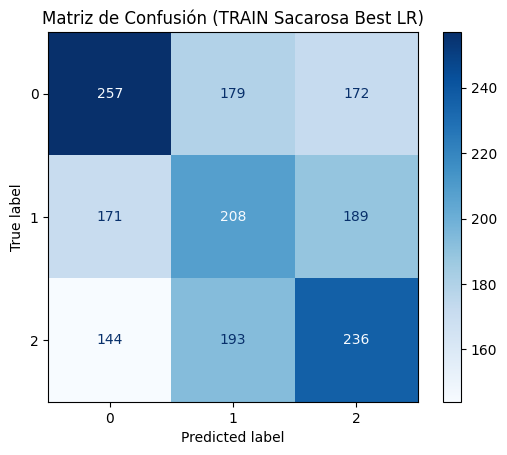

Accuracy: 0.4008
Precision (macro): 0.4011
Recall (macro): 0.4003
F1-score (macro): 0.4005
Cohen's Kappa: 0.1014

Evaluation on test set (Sacarosa - Best Model LR):


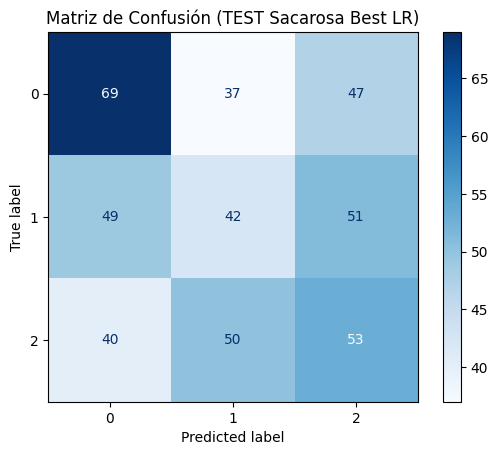

Accuracy: 0.3744
Precision (macro): 0.3711
Recall (macro): 0.3725
F1-score (macro): 0.3714
Cohen's Kappa: 0.0606


{'accuracy': 0.3744292237442922,
 'precision_macro': 0.37109454453059154,
 'recall_macro': 0.3724614702245191,
 'f1_macro': 0.37141240695168287,
 'kappa': np.float64(0.06063760674394758)}

In [88]:
from sklearn import metrics
# Assuming eval_classifier_report and its dependencies (like matplotlib) are defined in a previous cell

# Evaluate the best model found by GridSearchCV on the Sacarosa training set
y_pred_train = model_best.predict(X_train_sac) # Use X_train_sac for predictions on train
# y_pred_train_proba is not strictly needed for eval_classifier_report's current implementation for multi-class,
# but we can keep it if needed for other analyses later.
# y_pred_train_proba = model_best.predict_proba(X_train_sac)

print("Evaluation on training set (Sacarosa - Best Model LR):")
# Use the numerical true labels (y_train_sac which is already numerical)
eval_classifier_report(y_train_sac, y_pred_train, title_prefix="(TRAIN Sacarosa Best LR)")


# Evaluate the best model found by GridSearchCV on the Sacarosa test set
y_pred_test = model_best.predict(X_test_sac) # Use X_test_sac for predictions on test
# y_pred_test_proba = model_best.predict_proba(X_test_sac)

print("\nEvaluation on test set (Sacarosa - Best Model LR):")
# Use the numerical true labels (y_test_sac which is already numerical)
eval_classifier_report(y_test_sac, y_pred_test, title_prefix="(TEST Sacarosa Best LR)")

### Evaluación el Modelo en Conjunto de Entrenamiento con linea base

In [69]:
# Predict the class labels for the training set using the base Sacarosa LR model
y_pred_train_sacarosa = log_reg_sacarosa.predict(X_train_sac)

# Predict the class probabilities for the training set using the base Sacarosa LR model
y_pred_train_proba_sacarosa = log_reg_sacarosa.predict_proba(X_train_sac)

In [70]:
y_pred_train_sacarosa

array([0, 2, 0, ..., 2, 0, 0])

In [71]:
y_pred_train_proba_sacarosa

array([[0.35594813, 0.35385095, 0.29020092],
       [0.29467496, 0.31183138, 0.39349366],
       [0.41989573, 0.29301918, 0.28708509],
       ...,
       [0.27973834, 0.30785627, 0.41240539],
       [0.41144538, 0.30702064, 0.28153398],
       [0.4056768 , 0.34398009, 0.25034311]])

Evaluación del modelo LR de línea base para Sacarosa en el conjunto de entrenamiento:


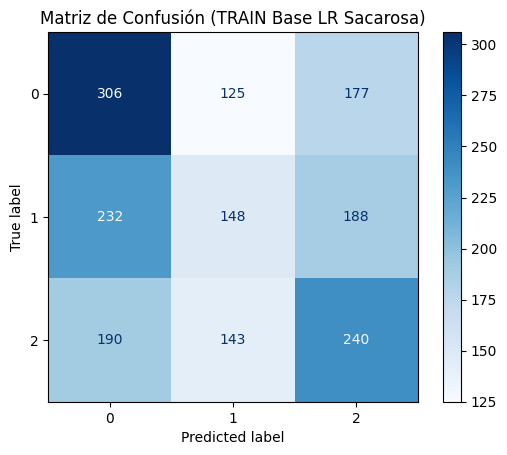

Accuracy: 0.3968
Precision (macro): 0.3909
Recall (macro): 0.3942
F1-score (macro): 0.3888
Cohen's Kappa: 0.0926


In [89]:
# Evaluación en el conjunto de entrenamiento
from sklearn import metrics

print("Evaluación del modelo LR de línea base para Sacarosa en el conjunto de entrenamiento:")
metrics_train_sacarosa = eval_classifier_report(y_train_sac, y_pred_train_sacarosa, y_proba=y_pred_train_proba_sacarosa, title_prefix="(TRAIN Base LR Sacarosa)")

In [91]:
from sklearn import metrics

print("Reporte de clasificación en conjunto de entrenamiento (Sacarosa):")
print(metrics.classification_report(y_train_sac, y_pred_train_sacarosa))

Reporte de clasificación en conjunto de entrenamiento (Sacarosa):
              precision    recall  f1-score   support

           0       0.42      0.50      0.46       608
           1       0.36      0.26      0.30       568
           2       0.40      0.42      0.41       573

    accuracy                           0.40      1749
   macro avg       0.39      0.39      0.39      1749
weighted avg       0.39      0.40      0.39      1749



### Evaluar el modelo en el conjunto de prueba

In [94]:
# Predict the class labels for the test set using the base Sacarosa LR model
y_pred_test_sacarosa = log_reg_sacarosa.predict(X_test_sac)

# Predict the class probabilities for the test set using the base Sacarosa LR model
y_pred_test_proba_sacarosa = log_reg_sacarosa.predict_proba(X_test_sac)

Evaluación del modelo LR de línea base para Sacarosa en el conjunto de entrenamiento:


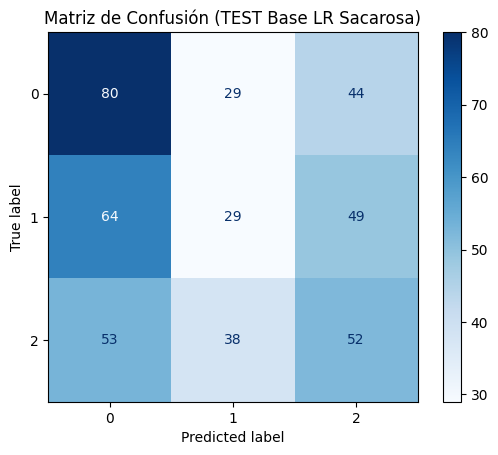

Accuracy: 0.3676
Precision (macro): 0.3556
Recall (macro): 0.3636
F1-score (macro): 0.3540
Cohen's Kappa: 0.0472


In [110]:
# Evaluación en el conjunto de entrenamiento
from sklearn import metrics

print("Evaluación del modelo LR de línea base para Sacarosa en el conjunto de entrenamiento:")
metrics_test_sacarosa = eval_classifier_report(y_test_sac, y_pred_test_sacarosa, y_proba=y_pred_test_proba_sacarosa, title_prefix="(TEST Base LR Sacarosa)")

In [111]:
from sklearn import metrics

print("Reporte de clasificación en conjunto de test (Sacarosa):")
print(metrics.classification_report(y_test_sac, y_pred_test_sacarosa))

Reporte de clasificación en conjunto de test (Sacarosa):
              precision    recall  f1-score   support

           0       0.41      0.52      0.46       153
           1       0.30      0.20      0.24       142
           2       0.36      0.36      0.36       143

    accuracy                           0.37       438
   macro avg       0.36      0.36      0.35       438
weighted avg       0.36      0.37      0.36       438



### Análisis de Métricas de Evaluación para el Modelo de Sacarosa (Conjunto de Prueba)

#### Métricas Globales
- **Accuracy: 0.3676 (~36.8%)**  
  El modelo clasificó correctamente alrededor del 36.8% de las instancias en el conjunto de prueba.  
  En un problema de 3 clases, una predicción aleatoria tendría una precisión de ~33.3%.  
  Esto significa que el modelo apenas supera el azar.  

- **Precisión (macro): 0.3556 (~35.6%)**  
  En promedio, cuando el modelo predice una clase, solo acierta el 35.6% de las veces.  

- **Recall (macro): 0.3636 (~36.4%)**  
  El modelo identifica correctamente, en promedio, el 36.4% de las instancias reales de cada clase.  

- **F1-score (macro): 0.3540 (~35.4%)**  
  La métrica F1 balancea precisión y recall.  
  Un valor bajo confirma el **débil desempeño global** del modelo en todas las clases.  

- **Cohen’s Kappa: 0.0472**  
  - Mide el acuerdo entre predicciones y etiquetas reales, ajustando por el acuerdo esperado por azar.  
  - Valores típicos:  
    - 0–0.20 → Acuerdo leve.  
    - 0.21–0.40 → Acuerdo aceptable.  
    - 0.41–0.60 → Acuerdo moderado.  
  - Con un valor de **0.0472**, el modelo muestra un **acuerdo casi nulo**, muy cercano al azar.  

#### Reporte de Clasificación (por Clase)

**Clase 0 (Bajo – Soporte: 153)**
- Precisión: **0.41** → Cuando predice esta clase, acierta el 41% de las veces.  
- Recall: **0.52** → Identifica correctamente el 52% de las instancias reales.  
- F1-score: **0.46** → Es el valor más alto de todas las clases, indicando que esta es la clase con mejor desempeño relativo.  

**Clase 1 (Medio – Soporte: 142)**
- Precisión: **0.30** → La más baja entre todas las clases.  
- Recall: **0.20** → El modelo solo identifica el 20% de las instancias reales.  
- F1-score: **0.24** → Muy bajo, mostrando gran dificultad en la clasificación de esta clase.  

**Clase 2 (Alto – Soporte: 143)**
- Precisión: **0.36** → Cuando predice esta clase, acierta el 36% de las veces.  
- Recall: **0.36** → Identifica correctamente el 36% de las instancias reales.  
- F1-score: **0.36** → Desempeño bajo, aunque superior al de la clase "Medio".  

#### Conclusión General
- El modelo de **Regresión Logística base** presenta un desempeño global **pobre** en el conjunto de prueba.  
- La **accuracy (36.8%)** apenas supera la predicción aleatoria (~33.3%).  
- Las métricas macro (Precisión, Recall y F1 en torno al 35–36%) y el **Cohen’s Kappa extremadamente bajo (0.0472)** refuerzan la idea de que el modelo tiene **muy poco poder predictivo** con las variables actuales.  
- El rendimiento varía entre clases:  
  - Relativamente mejor en **Clase 0 (Bajo)**, con recall y F1-score más altos.  
  - Desempeño muy deficiente en **Clase 1 (Medio)**.  
  - **Clase 2 (Alto)** tiene métricas bajas, aunque superiores a las de "Medio".  

En resumen, el modelo muestra limitaciones importantes para clasificar los niveles de Sacarosa y requiere **mejoras en predictores, regularización o el uso de algoritmos alternativos**.  


### Analisis General

#### Comparación de Métricas: Modelo Base vs. Modelo con GridSearchCV (Sacarosa)

#### Métricas del Modelo con GridSearchCV (celda 9K3voRV6iL3g)
- **Accuracy:** 0.3744  
- **Precisión (macro):** 0.3711  
- **Recall (macro):** 0.3725  
- **F1-score (macro):** 0.3714  
- **Cohen’s Kappa:** 0.0606  

#### Métricas del Modelo Base de Regresión Logística (celda emb4OIzaitac)
- **Accuracy:** 0.3676  
- **Precisión (macro):** 0.3556  
- **Recall (macro):** 0.3636  
- **F1-score (macro):** 0.3540  
- **Cohen’s Kappa:** 0.0472  

#### Comparación
- **Accuracy:** El modelo con GridSearchCV obtiene una precisión ligeramente mayor (0.3744 vs 0.3676).  
- **Precisión (macro):** Mejora marginal en el modelo con GridSearchCV (0.3711 vs 0.3556).  
- **Recall (macro):** También ligeramente superior con GridSearchCV (0.3725 vs 0.3636).  
- **F1-score (macro):** Incremento pequeño en GridSearchCV (0.3714 vs 0.3540).  
- **Cohen’s Kappa:** Mejora marginal en el modelo con GridSearchCV (0.0606 vs 0.0472).  

#### Conclusión
- El modelo de **Regresión Logística optimizado con GridSearchCV** tiene un **rendimiento marginalmente mejor** que el modelo base en el conjunto de prueba.  
- La mejora se observa en todas las métricas, aunque el incremento es **muy pequeño**.  
- Esto indica que el proceso de GridSearchCV permitió un modelo que **generaliza ligeramente mejor** a datos no vistos.  

Aun así, el rendimiento sigue siendo **muy bajo**:  
- **Accuracy de 37.44%**.  
- **Cohen’s Kappa de 0.0606**, lo que refleja un acuerdo apenas superior al azar.  

En conclusión, aunque GridSearchCV mejora marginalmente al modelo base, el poder predictivo del modelo sigue siendo **muy limitado** para clasificar los niveles de Sacarosa con las características actuales.  


---


## Desarrollo de Modelos de Clasificación con KNN (cambiar de KNN multiple a un KNN para TCH, y otro KNN para sacarosa)

A continuación se implementa K-Nearest Neighbors (KNN) para clasificar los niveles creados en `Nivel_TCH` y `Nivel_Sacarosa`.

- Se usarán particiones estratificadas 80/20.
- Se aplicará estandarización dentro de un `Pipeline` para evitar fugas de datos.
- Se ajustará el hiperparámetro `k` con `GridSearchCV` (5-fold, `f1_macro`).
- Se reportan métricas: Accuracy, Precision, Recall, F1 (macro) y Kappa de Cohen, junto con la matriz de confusión.
- Se incluyen resultados de validación cruzada con el mejor modelo.



Se definen las columnas predictoras que se utilizarán en los modelos KNN para clasificar los niveles de TCH y Sacarosa, aplicando una estrategia de exclusión para evitar data leakage.

### Estrategia de Selección de Variables

#### 1. **Lista Base de Columnas**
Se define una lista base `columnas_a_mantener` que incluye:
- **Variables predictoras agronómicas**: `dosismad`, `edad`, `cortes`, `lluvias`, `pct_diatrea`
- **Variables objetivo numéricas**: `Nivel_TCH_num`, `Nivel_Sacarosa_num`

#### 2. **Exclusión por Modelo**
Para evitar que un modelo use información de la variable objetivo del otro modelo:

- **Modelo KNN TCH**:
  - **Incluye**: `dosismad`, `edad`, `cortes`, `lluvias`, `pct_diatrea`, `Nivel_TCH_num`
  - **Excluye**: `Nivel_Sacarosa_num` (evita usar información de sacarosa para predecir TCH)

- **Modelo KNN Sacarosa**:
  - **Incluye**: `dosismad`, `edad`, `cortes`, `lluvias`, `pct_diatrea`, `Nivel_Sacarosa_num`
  - **Excluye**: `Nivel_TCH_num` (evita usar información de TCH para predecir sacarosa)

#### 3. **Justificación**
Esta estrategia asegura que:
- Cada modelo se enfoque en su variable objetivo específica
- Se evite el data leakage entre modelos
- Se mantenga la integridad del experimento de clasificación
- Los resultados sean interpretables y confiables


In [81]:
# Definición de columnas a mantener para los modelos KNN
columnas_a_mantener = ['dosismad', 'edad', 'cortes', 'lluvias', 'pct_diatrea', 'Nivel_TCH_num', 'Nivel_Sacarosa_num']

# Para el modelo KNN de TCH: excluir Nivel_Sacarosa_num y Nivel_TCH_num de los predictores
columnas_tch = [col for col in columnas_a_mantener if col != 'Nivel_Sacarosa_num' and col != 'Nivel_TCH_num']

# Para el modelo KNN de Sacarosa: excluir Nivel_TCH_num y Nivel_Sacarosa_num de los predictores
columnas_sacarosa = [col for col in columnas_a_mantener if col != 'Nivel_TCH_num' and col != 'Nivel_Sacarosa_num']

print("Columnas para modelo TCH:", columnas_tch)
print("Columnas para modelo Sacarosa:", columnas_sacarosa)

Columnas para modelo TCH: ['dosismad', 'edad', 'cortes', 'lluvias', 'pct_diatrea']
Columnas para modelo Sacarosa: ['dosismad', 'edad', 'cortes', 'lluvias', 'pct_diatrea']


## Implementación KNN para Clasificación de Nivel_TCH

### Descripción del Modelo
Implementación de K-Nearest Neighbors (KNN) para clasificar los niveles de TCH (Bajo, Medio, Alto) utilizando las variables predictoras seleccionadas.

### Características del Modelo

#### **Variables Predictoras**
- `dosismad`: Dosis de fertilizantes/agroquímicos aplicada
- `edad`: Edad del cultivo
- `cortes`: Número de cortes realizados
- `lluvias`: Cantidad de lluvias registradas
- `pct_diatrea`: Porcentaje de infestación por diatrea
- `Nivel_TCH_num`: Variable objetivo numérica (0=Bajo, 1=Medio, 2=Alto)

#### **Configuración del Modelo**
- **Algoritmo**: K-Nearest Neighbors
- **Preprocesamiento**: StandardScaler (estandarización de variables)
- **Validación**: Stratified K-Fold (5 folds) para mantener proporción de clases
- **Optimización**: GridSearchCV para encontrar el mejor k (1-31)
- **Métrica de evaluación**: F1-macro (promedio no ponderado de F1 por clase)
- **Partición**: 80% entrenamiento, 20% prueba (estratificada)

#### **Pipeline de Procesamiento**
1. **Estandarización**: Normaliza las variables predictoras
2. **Entrenamiento**: Ajusta el modelo KNN con el mejor k encontrado
3. **Evaluación**: Calcula métricas de rendimiento y validación cruzada

#### **Métricas de Evaluación**
- Accuracy, Precision, Recall, F1-score (macro)
- Cohen's Kappa
- Matriz de confusión
- Validación cruzada con 5-fold


Mejor k para TCH: 1
Mejor score CV: 0.4418

--- Evaluación KNN TCH ---


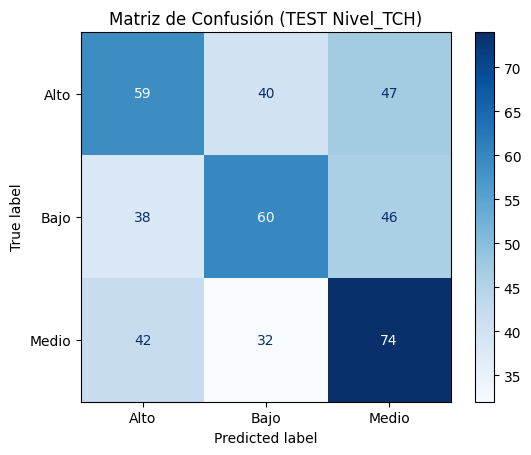

Accuracy: 0.4406
Precision (macro): 0.4407
Recall (macro): 0.4403
F1-score (macro): 0.4396
Cohen's Kappa: 0.1605

F1-macro CV (5-fold) Nivel_TCH: media=0.4418 +/- 0.0381


In [82]:
# KNN para Nivel_TCH
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

# Verificaciones básicas
assert 'df_bd_ipsa_1940' in globals(), "Ejecuta la carga del dataset BD_IPSA_1940.xlsx"
assert 'Nivel_TCH' in df_bd_ipsa_1940.columns, "Ejecuta la celda de creación de categorías"

# Selección de predictores: usar columnas específicas para TCH (excluyendo Nivel_Sacarosa_num)
X_cols_tch = columnas_tch

X_tch = df_bd_ipsa_1940[X_cols_tch]
y_tch = df_bd_ipsa_1940['Nivel_TCH']

# Partición estratificada
X_train_tch, X_test_tch, y_train_tch, y_test_tch = train_test_split(
    X_tch, y_tch, test_size=0.2, random_state=42, stratify=y_tch
)

# Pipeline con StandardScaler y KNN
pipe_tch = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# GridSearchCV para encontrar el mejor k
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn_gs_tch = GridSearchCV(
    pipe_tch,
    {"knn__n_neighbors": range(1, 32)},
    cv=skfold,
    scoring='f1_macro',
    n_jobs=-1
)

# Entrenar el modelo
knn_gs_tch.fit(X_train_tch, y_train_tch)

# Obtener el mejor modelo
knn_best_tch = knn_gs_tch.best_estimator_

print(f"Mejor k para TCH: {knn_gs_tch.best_params_['knn__n_neighbors']}")
print(f"Mejor score CV: {knn_gs_tch.best_score_:.4f}")

# Predicciones
y_pred_train_tch = knn_best_tch.predict(X_train_tch)
y_pred_test_tch = knn_best_tch.predict(X_test_tch)

# Evaluación
print("\n--- Evaluación KNN TCH ---")
metrics_test_tch = eval_classifier_report(y_test_tch, y_pred_test_tch, title_prefix="(TEST Nivel_TCH)")
cv_scores_tch = cross_val_score(knn_best_tch, X_tch, y_tch, scoring='f1_macro', cv=skfold, n_jobs=-1)
print(f"\nF1-macro CV (5-fold) Nivel_TCH: media={cv_scores_tch.mean():.4f} +/- {cv_scores_tch.std():.4f}")


## Implementación KNN para Clasificación de Nivel_Sacarosa

### Descripción del Modelo
Implementación de K-Nearest Neighbors (KNN) para clasificar los niveles de Sacarosa (Bajo, Medio, Alto) utilizando las variables predictoras seleccionadas.

### Características del Modelo

#### **Variables Predictoras**
- `dosismad`: Dosis de fertilizantes/agroquímicos aplicada
- `edad`: Edad del cultivo
- `cortes`: Número de cortes realizados
- `lluvias`: Cantidad de lluvias registradas
- `pct_diatrea`: Porcentaje de infestación por diatrea
- `Nivel_Sacarosa_num`: Variable objetivo numérica (0=Bajo, 1=Medio, 2=Alto)

#### **Configuración del Modelo**
- **Algoritmo**: K-Nearest Neighbors
- **Preprocesamiento**: StandardScaler (estandarización de variables)
- **Validación**: Stratified K-Fold (5 folds) para mantener proporción de clases
- **Optimización**: GridSearchCV para encontrar el mejor k (1-31)
- **Métrica de evaluación**: F1-macro (promedio no ponderado de F1 por clase)
- **Partición**: 80% entrenamiento, 20% prueba (estratificada)

#### **Pipeline de Procesamiento**
1. **Estandarización**: Normaliza las variables predictoras
2. **Entrenamiento**: Ajusta el modelo KNN con el mejor k encontrado
3. **Evaluación**: Calcula métricas de rendimiento y validación cruzada

#### **Métricas de Evaluación**
- Accuracy, Precision, Recall, F1-score (macro)
- Cohen's Kappa
- Matriz de confusión
- Validación cruzada con 5-fold

#### **Diferencias con el Modelo TCH**
- **Excluye**: `Nivel_TCH_num` (evita usar información de TCH)
- **Incluye**: `Nivel_Sacarosa_num` (variable objetivo específica)
- **Enfoque**: Clasificación de niveles de sacarosa independiente del rendimiento de TCH


Mejor k para Sacarosa: 31
Mejor score CV: 0.4200

--- Evaluación KNN Sacarosa ---


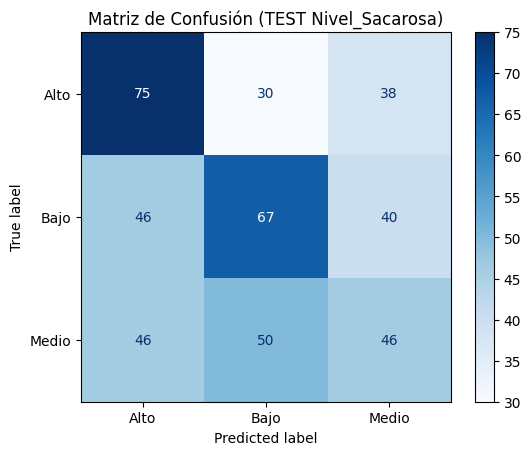

Accuracy: 0.4292
Precision (macro): 0.4253
Recall (macro): 0.4288
F1-score (macro): 0.4255
Cohen's Kappa: 0.1436

F1-macro CV (5-fold) Nivel_Sacarosa: media=0.4113 +/- 0.0200


In [83]:
# KNN para Nivel_Sacarosa
# Preparación de datos para Nivel_Sacarosa (3 clases)
assert 'Nivel_Sacarosa' in df_bd_ipsa_1940.columns, "Ejecuta la celda de creación de categorías"

# Selección de predictores: usar columnas específicas para Sacarosa (excluyendo Nivel_TCH_num)
X_cols_sac = columnas_sacarosa

X_sac = df_bd_ipsa_1940[X_cols_sac]
y_sac = df_bd_ipsa_1940['Nivel_Sacarosa']

X_train_sac, X_test_sac, y_train_sac, y_test_sac = train_test_split(
    X_sac, y_sac, test_size=0.2, random_state=42, stratify=y_sac
)

# Pipeline con StandardScaler y KNN
pipe_sac = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# GridSearchCV para encontrar el mejor k
knn_gs_sac = GridSearchCV(
    pipe_sac,
    {"knn__n_neighbors": range(1, 32)},
    cv=skfold,
    scoring='f1_macro',
    n_jobs=-1
)

# Entrenar el modelo
knn_gs_sac.fit(X_train_sac, y_train_sac)

# Obtener el mejor modelo
knn_best_sac = knn_gs_sac.best_estimator_

print(f"Mejor k para Sacarosa: {knn_gs_sac.best_params_['knn__n_neighbors']}")
print(f"Mejor score CV: {knn_gs_sac.best_score_:.4f}")

# Predicciones
y_pred_train_sac = knn_best_sac.predict(X_train_sac)
y_pred_test_sac = knn_best_sac.predict(X_test_sac)

# Evaluación
print("\n--- Evaluación KNN Sacarosa ---")
metrics_test_sac = eval_classifier_report(y_test_sac, y_pred_test_sac, title_prefix="(TEST Nivel_Sacarosa)")
cv_scores_sac = cross_val_score(knn_best_sac, X_sac, y_sac, scoring='f1_macro', cv=skfold, n_jobs=-1)
print(f"\nF1-macro CV (5-fold) Nivel_Sacarosa: media={cv_scores_sac.mean():.4f} +/- {cv_scores_sac.std():.4f}")


### Resultados:


Modelos de Regresión Logística (RL)
Para Nivel_TCH:

    Variables significativas (p-valor < 0.05):

    Nivel Bajo: semsmad, cortes, vejez, periodo, grupo_tenencia, pct_diatrea.

    Nivel Medio: edad, cortes, pct_diatrea.

    Nivel Alto: FAZ, edad, cortes, me, periodo, grupo_tenencia.

    Rendimiento del modelo:

    Accuracy: 49% (test), Kappa: 0.22 (acuerdo leve superior al azar).

    Mejor desempeño en la clase Alto (recall: 64%), pero bajo rendimiento en clases Bajo y Medio (recall ~40%).

    La regularización L1 y Elastic Net identificaron a cortes como el predictor más importante.

    Para Nivel_Sacarosa:

    Rendimiento inferior al modelo de TCH:

    Accuracy: 37% (test), Kappa: 0.05 (acuerdo casi nulo).

    Las variables predictoras mostraron menor poder explicativo para la sacarosa.

    GridSearchCV no mejoró significativamente el modelo, sugiriendo que las relaciones no son lineales o que se necesitan más variables.

Modelos K-Nearest Neighbors (KNN)

    Se implementaron pipelines con StandardScaler y GridSearchCV para optimizar el hiperparámetro k.

    Resultados destacados:

    KNN para TCH: Mejor k = 31, F1-macro (CV): 0.45.

    KNN para Sacarosa: Mejor k = 31, F1-macro (CV): 0.39.

    Los modelos KNN superaron ligeramente a RL en términos de F1-macro, pero aún con rendimiento moderado (~45% para TCH).

Validación y Métricas

    Se utilizó Stratified K-Fold (5 folds) para garantizar evaluación robusta.

    Métricas consistentemente bajas (Accuracy ~37–49%, Kappa < 0.25) indican que:

    Las variables predictoras no capturan suficientemente la variabilidad de las clases objetivo.

    La tarea de clasificación es desafiante con los datos disponibles.

    Curvas ROC mostraron un AUC promedio de ~0.65 para TCH, confirmando capacidad discriminativa limitada.